## Jeopardy NLTK Word Cloud & TF- IDF Analysis

In [1]:
#Import dependencies
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import Counter
import re
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.decomposition import NMF

path = ('./Resources/QuestionsSQL.csv')


In [2]:
questions_csv = pd.read_csv(path).drop(columns = 'Unnamed: 0')

In [3]:
questions_csv

,game_id,question_text,answer,category
0,3901,"A longshot who wins, or a ""Star Wars"" comic bo...",a dark horse,"""DAR"""
1,3901,"A term of endearment, like for my Clementine",darling,"""DAR"""
2,3901,It's the Turkish strait seen here,the Dardanelles,"""DAR"""
3,3901,The inner bull's eye is commonly worth 50 poin...,darts,"""DAR"""
4,3901,This capital of Australia's Northern Territory...,Darwin,"""DAR"""
...,...,...,...,...
49890,4385,Alexander Solzhenitsyn spent years in the Gula...,Stalin,WRITERS IN PRISON
49891,4385,"An author, statesman & saint, he was jailed in...",Thomas More,WRITERS IN PRISON
49892,4385,He spent 30 days in jail for vagrancy in 1894 ...,Jack London,WRITERS IN PRISON
49893,4385,"The ""idiot""! He got mixed up with the Petrashe...",Dostoyevsky,WRITERS IN PRISON


## NLTK processes to tokenize bag of words from Jeopardy Data

In [4]:
# let joins all the title rows and tokenize them into words
questions =" ".join(questions_csv['question_text'])
answers = " ".join(questions_csv['answer'])
categories = " ".join(questions_csv['category'])
question_words = word_tokenize(questions)
answer_words = word_tokenize(answers)
category_words = word_tokenize(categories)

In [5]:
#Create a function to iterate through data, normalize the data, remove all stopwords,
# and produce lemmas (basic form of words)
def clean_words(new_tokens):
    new_tokens = [t.lower() for t in new_tokens]
    new_tokens =[t for t in new_tokens if t not in stopwords.words('english')]
    new_tokens = [t for t in new_tokens if t.isalpha()]
    lemmatizer = WordNetLemmatizer()
    new_tokens =[lemmatizer.lemmatize(t) for t in new_tokens]
    return new_tokens

In [6]:
question_word_freq = clean_words(question_words)
answer_word_freq = clean_words(answer_words)
category_word_freq = clean_words(category_words)

In [7]:
#Create a count of common words found in Jeopardy questions, answers, and categories
question_freq = Counter(question_word_freq)

In [8]:
answer_freq = Counter(answer_word_freq)

In [9]:
category_freq = Counter(category_word_freq)

In [10]:
#Convert enumerated word counts into dataframes
question_count_df = pd.DataFrame(question_freq.items(),columns=['Word','Count'])
answer_count_df = pd.DataFrame(answer_freq.items(),columns=['Word','Count'])
category_count_df = pd.DataFrame(category_freq.items(),columns=['Word','Count'])


In [11]:
#Explored dataframes to ensure no null values existed
question_count_df.sort_values(by = 'Count', ascending = False)

question_count_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39529 entries, 0 to 39528
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Word    39529 non-null  object
 1   Count   39529 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 617.8+ KB


In [12]:
answer_count_df.sort_values(by =['Count'], ascending = False)

answer_count_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19705 entries, 0 to 19704
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Word    19705 non-null  object
 1   Count   19705 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 308.0+ KB


In [13]:
#Wrote dataframes to *.CSV for further analysis
question_count_df.to_csv('question_count_NLTK.csv')
answer_count_df.to_csv('answer_count_NLTK.csv')
category_count_df.to_csv('category_count_NLTK.csv')


In [14]:
#Converted dataframe to a dicitionary of tuples for processing by WordCloud
data_Cat = dict(category_count_df[['Word', 'Count']].itertuples(index=False, name=None))
data_Ques = dict(question_count_df[['Word', 'Count']].itertuples(index=False, name=None))
data_Ans = dict(answer_count_df[['Word', 'Count']].itertuples(index=False, name=None))



## Word Cloud Visuals

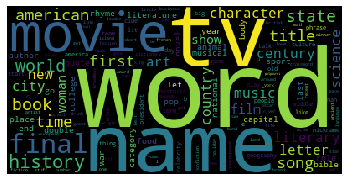

<Figure size 2880x1440 with 0 Axes>

In [15]:
#Created WordCloud Visuals for later presentation
wc_Cat = WordCloud().generate_from_frequencies(data_Cat)
wc_Cat.to_file("./Images/Category_Cloud_NLTK.png")

plt.imshow(wc_Cat)
plt.axis('off')
plt.figure( figsize=(40,20) )
plt.show()

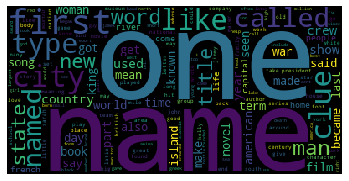

<Figure size 2880x1440 with 0 Axes>

In [16]:
wc_Cat = WordCloud().generate_from_frequencies(data_Ques)
wc_Cat.to_file("./Images/Question_Cloud_NLTK.png")

plt.imshow(wc_Cat)
plt.axis('off')
plt.figure( figsize=(40,20) )
plt.show()

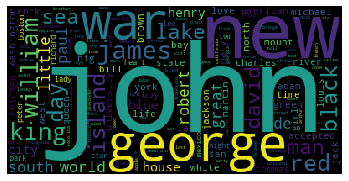

<Figure size 2880x1440 with 0 Axes>

In [17]:
wc_Cat = WordCloud().generate_from_frequencies(data_Ans)
wc_Cat.to_file("./Images/Answer_Cloud_NLTK.png")

plt.imshow(wc_Cat)
plt.axis('off')
plt.figure( figsize=(40,20) )
plt.show()

## Calculating TF-IDF Values and performing supervised machine learning to evaluate whether a Jeopardy category has a strong influence on natural language predictions


In [18]:
questions_csv

questions_csv['text'] = questions_csv['category'] + ' ' + questions_csv['question_text'] + ' ' + questions_csv['answer'].astype(str)

In [19]:
text = " ".join(questions_csv['text'])
text = word_tokenize(text)
text = clean_words(text)

In [20]:
v = TfidfVectorizer()
transformed_output = v.fit_transform(text)
print(v.vocabulary_)

{'dar': 10107, 'longshot': 23738, 'win': 44342, 'star': 38392, 'war': 43695, 'comic': 8246, 'book': 4759, 'publisher': 32167, 'dark': 10124, 'horse': 19115, 'term': 40330, 'endearment': 13106, 'like': 23330, 'clementine': 7789, 'darling': 10135, 'turkish': 41845, 'strait': 38800, 'seen': 35944, 'dardanelles': 10112, 'inner': 20290, 'bull': 5593, 'eye': 14060, 'commonly': 8310, 'worth': 44665, 'point': 31048, 'game': 16000, 'dart': 10150, 'capital': 6253, 'australia': 2620, 'northern': 27967, 'territory': 40369, 'named': 27156, 'evolutionary': 13757, 'scientist': 35631, 'darwin': 10159, 'art': 2177, 'artist': 2206, 'depicting': 10745, 'native': 27283, 'american': 1275, 'george': 16338, 'catlin': 6661, 'often': 28443, 'painted': 29306, 'beast': 3539, 'assiniboine': 2347, 'indian': 20050, 'pursuing': 32335, 'snowshoe': 37533, 'buffalo': 5546, 'impressionist': 19899, 'painter': 29307, 'father': 14331, 'jean': 21057, 'director': 11281, 'rule': 34775, 'renoir': 33628, 'thomas': 40597, 'sully

In [21]:
all_feature_names = v.get_feature_names_out(text)

for word in all_feature_names:
    index = v.vocabulary_.get(word)
    print(f'{word} {v.idf_[index]}')

aa 12.641818115246211
aaa 12.459496558452257
aaaee 13.558108847120366
aachen 13.558108847120366
aahs 13.558108847120366
aak 13.558108847120366
aalenian 13.558108847120366
aalto 13.558108847120366
aam 13.152643739012202
aar 13.558108847120366
aardman 13.558108847120366
aardvark 12.641818115246211
aardwolf 13.558108847120366
aaron 10.359435729569684
aarp 12.459496558452257
aau 13.558108847120366
ab 11.612198698065052
aba 12.86496166656042
ababa 12.641818115246211
abaca 13.558108847120366
aback 13.152643739012202
abactor 13.558108847120366
abacus 12.305345878624998
abaddon 13.558108847120366
abamasum 13.558108847120366
abandon 12.459496558452257
abandoned 11.47866730544053
abandoning 13.558108847120366
abated 13.558108847120366
abatement 13.558108847120366
abba 12.171814486000475
abbas 13.152643739012202
abbasid 13.558108847120366
abbe 13.558108847120366
abbev 12.459496558452257
abbey 10.46706639376205
abbi 13.558108847120366
abbie 12.86496166656042
abbot 12.459496558452257
abbott 11.9486

acronym 10.280964114128189
acrophobia 13.558108847120366
acropolis 12.171814486000475
across 9.281442728104311
acrylonitrile 13.558108847120366
acsr 13.558108847120366
act 8.49235425380303
acta 13.152643739012202
actaeon 13.558108847120366
actar 13.558108847120366
acted 12.054031450344091
actifed 13.558108847120366
actin 13.558108847120366
acting 10.300012309098884
actinide 13.558108847120366
actinium 13.558108847120366
action 9.240620733584056
actium 12.641818115246211
activate 13.152643739012202
activation 13.558108847120366
active 10.46706639376205
actively 13.152643739012202
activism 12.641818115246211
activist 11.30681704851387
activity 9.844536780416059
acton 13.152643739012202
actor 8.252319465733628
actress 8.885280012658459
actual 10.562376573566375
actually 9.414974120728834
actuallynph 13.558108847120366
actuary 13.152643739012202
acubens 13.558108847120366
acuity 13.558108847120366
acumen 13.152643739012202
acupressure 13.152643739012202
acupuncture 12.86496166656042
acura 

aid 9.96079658653192
aida 12.054031450344091
aidan 13.558108847120366
aide 11.766349377892311
aided 11.948670934686266
aider 13.558108847120366
aiding 12.305345878624998
aiello 13.558108847120366
aigu 13.558108847120366
aiken 13.152643739012202
aikido 13.558108847120366
aikman 12.86496166656042
ail 12.459496558452257
ailanthus 13.558108847120366
aileen 13.558108847120366
aileron 13.558108847120366
ailes 13.558108847120366
ailey 13.558108847120366
ailing 12.86496166656042
ailment 11.47866730544053
ailsa 13.558108847120366
aim 10.883960197693836
aimed 12.171814486000475
aimee 12.641818115246211
aiming 13.558108847120366
aimless 13.558108847120366
aimlessly 12.86496166656042
aint 12.459496558452257
ainu 13.152643739012202
aioli 13.152643739012202
aip 13.152643739012202
air 8.66400736928006
airbags 13.558108847120366
airbill 13.558108847120366
airbnb 13.152643739012202
airborne 12.459496558452257
airbrush 13.558108847120366
airbus 12.86496166656042
aircraft 10.339233022252165
aire 11.76634

aly 13.558108847120366
alyosha 12.86496166656042
alyson 13.558108847120366
alyssa 13.152643739012202
alzheimer 12.86496166656042
ama 12.054031450344091
amadeus 12.054031450344091
amadinda 13.558108847120366
amagansett 13.558108847120366
amahl 13.558108847120366
amaize 13.558108847120366
amal 13.152643739012202
amalgam 12.86496166656042
amalgamate 13.558108847120366
amalgamated 13.558108847120366
amalie 13.558108847120366
amalthea 13.558108847120366
amana 12.86496166656042
amanda 11.85336075488194
amanita 13.558108847120366
amano 13.558108847120366
amanuensis 13.558108847120366
amapa 13.558108847120366
amar 13.558108847120366
amare 13.558108847120366
amaretto 13.558108847120366
amarillo 12.641818115246211
amaro 13.558108847120366
amaru 13.558108847120366
amass 13.558108847120366
amassed 13.558108847120366
amateur 11.612198698065052
amati 13.152643739012202
amatitan 13.558108847120366
amatoria 13.558108847120366
amauti 13.558108847120366
amazed 13.152643739012202
amazement 13.55810884712

anonos 13.558108847120366
anonymous 12.054031450344091
anonymously 13.558108847120366
anopheles 13.152643739012202
anorak 13.558108847120366
another 8.554162541174907
anouilh 13.558108847120366
ansari 13.152643739012202
anschluss 13.152643739012202
ansel 12.305345878624998
ansom 13.558108847120366
answer 9.785347909025727
answered 12.459496558452257
answering 13.152643739012202
ant 10.613669867953925
antacid 12.86496166656042
antagonist 12.641818115246211
antagonize 13.558108847120366
antananarivo 13.558108847120366
antarctic 11.85336075488194
antarctica 11.03238020281211
antares 12.641818115246211
ante 11.418042683624096
anteater 12.054031450344091
antebellum 12.305345878624998
antecedent 13.558108847120366
antediluvian 13.152643739012202
antelope 11.360884269784147
antenna 11.85336075488194
anterior 12.86496166656042
anterograde 13.558108847120366
anthem 10.12412164263522
anthemic 13.558108847120366
anther 13.558108847120366
anthill 13.558108847120366
anthocyanins 13.152643739012202


argument 11.47866730544053
argus 12.86496166656042
argyle 13.558108847120366
ari 12.054031450344091
aria 11.85336075488194
ariadne 13.152643739012202
ariana 12.054031450344091
arianna 12.459496558452257
arid 12.305345878624998
aridisol 13.558108847120366
ariel 11.766349377892311
aries 12.305345878624998
arigato 13.558108847120366
arimaspians 13.558108847120366
arimathea 13.558108847120366
arion 13.558108847120366
ariosto 13.558108847120366
aris 13.558108847120366
arise 12.305345878624998
arises 13.558108847120366
arising 13.152643739012202
arista 13.558108847120366
aristarchus 13.152643739012202
aristide 12.86496166656042
aristocracy 13.152643739012202
aristocrat 12.641818115246211
aristocratic 13.558108847120366
aristodemus 13.558108847120366
aristophanes 12.641818115246211
aristotle 11.115761811751161
arithmetic 12.171814486000475
arizona 9.636135510839052
ark 11.5432058265781
arkansan 13.558108847120366
arkansas 10.38005501677242
arkham 13.558108847120366
arkin 13.152643739012202
ar

atheistic 13.558108847120366
athena 11.418042683624096
athenaeum 13.558108847120366
atheneum 13.558108847120366
athenian 11.85336075488194
athens 10.49005591198675
atherosclerosis 13.558108847120366
athlete 9.808604771189994
athletic 11.418042683624096
athletics 12.86496166656042
athol 13.558108847120366
atholl 13.558108847120366
athos 12.641818115246211
athsma 13.558108847120366
athwart 13.558108847120366
atilliator 13.558108847120366
ation 11.766349377892311
ative 13.558108847120366
atkins 12.641818115246211
atkinson 13.152643739012202
atlanta 10.208204759845762
atlantans 13.558108847120366
atlantic 9.45546548208357
atlantis 12.054031450344091
atlas 10.640338115036087
atlasov 13.152643739012202
atlatl 13.558108847120366
atm 11.948670934686266
atmosphere 10.640338115036087
atmospheric 11.25552375412632
atoll 11.766349377892311
atom 10.319430394955985
atomic 10.076868757784673
atomium 13.558108847120366
atomizer 13.152643739012202
atoned 13.558108847120366
atonement 12.641818115246211


bachmann 13.558108847120366
bacillus 12.459496558452257
back 7.864376708317667
backbeat 13.558108847120366
backbencher 13.558108847120366
backboard 13.558108847120366
backbone 11.948670934686266
backcombing 13.558108847120366
backcountry 13.558108847120366
backdating 13.558108847120366
backdraft 13.558108847120366
backdrop 12.171814486000475
backed 12.171814486000475
backfield 13.558108847120366
backfire 13.558108847120366
backgammon 12.641818115246211
background 11.160213574321995
backhand 13.152643739012202
backhoe 13.558108847120366
backing 11.115761811751161
backlash 12.86496166656042
backless 12.86496166656042
backlighting 13.558108847120366
backlog 13.558108847120366
backlot 13.558108847120366
backman 13.558108847120366
backpack 13.152643739012202
backronym 13.558108847120366
backseat 13.558108847120366
backside 13.558108847120366
backspace 13.558108847120366
backstabbing 13.558108847120366
backstage 12.305345878624998
backstop 13.558108847120366
backstory 13.152643739012202
back

barth 13.558108847120366
bartha 13.558108847120366
bartholdi 13.558108847120366
bartholomew 12.641818115246211
bartimaeus 13.558108847120366
bartleby 12.86496166656042
bartles 13.558108847120366
bartlet 13.558108847120366
bartlett 10.72489550306415
bartok 13.152643739012202
barton 11.948670934686266
baruchel 13.558108847120366
barwa 13.558108847120366
baryshnikov 12.459496558452257
barzani 13.558108847120366
basal 13.558108847120366
basalt 13.152643739012202
basaltic 13.558108847120366
basciano 13.558108847120366
bascio 13.558108847120366
bascombe 13.558108847120366
base 9.532757156385216
baseball 8.968052298942322
based 8.627238521492973
baseketball 13.558108847120366
basel 12.86496166656042
baseless 13.152643739012202
baseman 12.641818115246211
basement 12.171814486000475
basenji 13.558108847120366
bash 12.641818115246211
bashar 13.152643739012202
bashed 13.558108847120366
bashevis 13.152643739012202
bashful 12.641818115246211
basho 13.558108847120366
basic 10.061601285653886
basical

bellyache 13.558108847120366
belmont 12.305345878624998
belmopan 12.86496166656042
beloit 13.152643739012202
belon 13.558108847120366
belonephobia 13.558108847120366
belong 11.30681704851387
belonged 11.206733589956889
belonging 11.948670934686266
belongs 11.206733589956889
beloved 10.15691146545821
belshazzar 13.558108847120366
belt 10.401108425970254
belted 12.641818115246211
belteshazzar 13.558108847120366
beltway 12.054031450344091
beluga 12.305345878624998
belushi 12.641818115246211
belvedere 12.641818115246211
bely 13.558108847120366
belzer 13.558108847120366
bemelmans 13.558108847120366
bemer 13.558108847120366
bemidji 13.152643739012202
bemoaned 13.558108847120366
ben 9.3534162277294
bena 13.558108847120366
benadryl 13.558108847120366
benard 13.558108847120366
benatar 12.641818115246211
benazir 12.641818115246211
bench 11.85336075488194
benchley 13.558108847120366
benchmark 13.558108847120366
benchmate 13.558108847120366
benchwarmer 13.558108847120366
bend 10.955419161675982
be

birdseed 13.558108847120366
birdseye 13.558108847120366
biretta 13.152643739012202
birkenau 13.558108847120366
birkenhead 13.558108847120366
birkenstock 13.558108847120366
birkenstocks 13.152643739012202
birkhead 13.152643739012202
birkin 13.558108847120366
birley 13.558108847120366
birmingham 11.766349377892311
biro 13.558108847120366
biron 13.558108847120366
birth 9.656136177545722
birthdate 13.152643739012202
birthday 9.762619657948171
birthing 13.152643739012202
birthmark 13.152643739012202
birthplace 10.640338115036087
birthright 13.152643739012202
birthstone 12.171814486000475
birthstones 11.5432058265781
biru 13.558108847120366
biscay 11.948670934686266
biscayne 12.459496558452257
biscotti 13.152643739012202
biscuit 12.171814486000475
bisect 13.558108847120366
bisecting 13.152643739012202
bishop 10.208204759845762
bismarck 11.418042683624096
bismo 13.558108847120366
bismuth 13.558108847120366
bison 11.766349377892311
bisou 13.152643739012202
bisque 13.152643739012202
bissell 13.

boil 12.305345878624998
boiled 11.948670934686266
boiler 13.558108847120366
boilermaker 13.152643739012202
boilermakers 13.558108847120366
boilerplate 13.558108847120366
boilerroom 13.558108847120366
boiling 11.206733589956889
boingo 13.152643739012202
bois 12.641818115246211
boise 12.171814486000475
boisterous 13.152643739012202
boit 13.558108847120366
boitano 13.558108847120366
bojack 13.558108847120366
bok 13.152643739012202
boko 13.152643739012202
bol 13.558108847120366
bola 13.558108847120366
bold 11.03238020281211
bolder 13.558108847120366
boldly 12.641818115246211
boldness 12.641818115246211
bolduan 13.152643739012202
bolena 13.558108847120366
bolero 12.171814486000475
boleyn 11.612198698065052
bolide 13.558108847120366
bolingbroke 13.558108847120366
bolivar 12.054031450344091
bolivarian 13.558108847120366
bolivia 10.850058646018155
bolivian 13.152643739012202
bolkonsky 13.558108847120366
boll 12.641818115246211
bolling 12.86496166656042
bollingen 13.558108847120366
bollinger 13

brahe 12.459496558452257
brahma 12.86496166656042
brahman 13.558108847120366
brahmin 13.558108847120366
brahms 12.171814486000475
braid 12.641818115246211
braided 12.86496166656042
braille 11.948670934686266
brain 9.796908731426804
brainchild 13.558108847120366
brainerd 13.558108847120366
brainiac 13.558108847120366
brainstorming 13.152643739012202
brainteasers 13.152643739012202
braintree 13.558108847120366
brainwashed 13.558108847120366
brainwashing 13.558108847120366
brainwave 13.558108847120366
brainy 13.558108847120366
braj 13.558108847120366
brake 11.766349377892311
brakeman 13.152643739012202
braking 13.558108847120366
bram 12.171814486000475
bramani 13.558108847120366
bramble 13.558108847120366
bran 12.459496558452257
branagh 12.641818115246211
branch 9.506323899317062
branched 13.558108847120366
branching 13.558108847120366
brand 8.215774595155555
branded 12.054031450344091
brandeis 12.641818115246211
branden 13.558108847120366
brandenburg 12.171814486000475
brandenburgers 13.

bu 12.459496558452257
bubba 12.459496558452257
bubble 10.955419161675982
bubbling 13.152643739012202
bubbly 13.152643739012202
bubka 13.558108847120366
bubonic 13.152643739012202
bucatinsky 13.558108847120366
buccaneer 12.054031450344091
bucephala 13.558108847120366
bucephalus 13.558108847120366
buchan 13.558108847120366
buchanan 11.418042683624096
buchannon 13.558108847120366
bucharest 12.305345878624998
buche 13.558108847120366
buchheim 13.558108847120366
buchner 13.558108847120366
buck 10.24392284244784
buckbeak 13.558108847120366
bucket 10.883960197693836
bucketlike 13.558108847120366
buckeye 12.171814486000475
buckhead 13.558108847120366
buckingham 11.948670934686266
buckle 12.86496166656042
buckled 13.558108847120366
buckley 12.054031450344091
buckman 13.558108847120366
buckminster 12.305345878624998
buckner 13.558108847120366
buckskin 13.558108847120366
buckwheat 12.305345878624998
bucky 13.558108847120366
buckyball 13.558108847120366
buco 13.558108847120366
bucolic 13.558108847

caerphilly 13.152643739012202
caesar 10.076868757784673
caesarea 13.558108847120366
caesarion 13.558108847120366
caesura 13.558108847120366
cafe 11.612198698065052
cafeteria 13.558108847120366
cafezinhos 13.558108847120366
caffe 13.558108847120366
caffeinated 13.558108847120366
caffeine 12.459496558452257
café 13.152643739012202
cagayan 13.558108847120366
cage 10.667737089224202
caged 12.86496166656042
cagliari 13.558108847120366
cagney 12.459496558452257
cah 13.152643739012202
cahill 13.558108847120366
cahit 13.558108847120366
cahoot 13.152643739012202
cahuenga 13.558108847120366
caiaphas 13.558108847120366
caicos 13.152643739012202
caillebotte 13.558108847120366
caillie 13.558108847120366
caiman 13.152643739012202
cain 11.160213574321995
caine 11.766349377892311
cair 13.558108847120366
cairene 13.558108847120366
cairn 12.86496166656042
cairnholm 13.558108847120366
cairo 10.72489550306415
caisson 13.558108847120366
caithness 13.558108847120366
caitlyn 13.558108847120366
caius 13.55810

cardin 13.558108847120366
cardinal 10.785520124880584
cardini 13.558108847120366
cardio 12.459496558452257
cardiologist 13.558108847120366
cardiology 13.152643739012202
cardiotachometer 13.558108847120366
cardiovascular 13.558108847120366
care 9.636135510839052
cared 12.641818115246211
career 9.86922939300643
carefree 13.558108847120366
careful 11.160213574321995
carefully 12.171814486000475
caregiver 13.558108847120366
carel 13.558108847120366
careless 12.86496166656042
carell 12.171814486000475
caress 13.558108847120366
caretaker 13.152643739012202
carey 11.30681704851387
cargo 12.171814486000475
carhenge 13.152643739012202
carhop 13.558108847120366
carib 13.558108847120366
caribbean 9.707961245410308
caribou 13.558108847120366
caricature 13.152643739012202
carillon 12.641818115246211
carillonneur 13.558108847120366
carina 13.152643739012202
caring 13.558108847120366
caringly 13.558108847120366
carinthia 13.558108847120366
carioca 13.558108847120366
carisbrooke 13.558108847120366
car

celsius 11.85336075488194
celt 13.558108847120366
celtic 11.418042683624096
cement 12.054031450344091
cemented 13.558108847120366
cementum 13.558108847120366
cemetary 13.558108847120366
cemetery 10.262271981116037
cena 13.558108847120366
cenatio 13.558108847120366
cenerentola 13.558108847120366
cenozoic 13.558108847120366
censor 12.459496558452257
censored 13.152643739012202
censorship 12.86496166656042
censure 13.152643739012202
census 11.612198698065052
cent 11.073202197332366
centaur 12.641818115246211
centauri 12.641818115246211
centaurus 13.558108847120366
centavo 13.558108847120366
centenarian 13.558108847120366
centenary 13.152643739012202
centennial 11.766349377892311
centeotl 13.152643739012202
center 8.602281789519104
centered 11.766349377892311
centerfielder 13.558108847120366
centerfold 13.152643739012202
centering 13.558108847120366
centerless 13.558108847120366
centerpiece 11.85336075488194
centerville 13.558108847120366
centigrade 13.152643739012202
centimeter 12.8649616

chesapeake 11.418042683624096
cheshire 11.47866730544053
chesil 13.558108847120366
chesimard 13.558108847120366
chesney 13.558108847120366
chespin 13.558108847120366
chess 10.513586409396943
chessboard 12.171814486000475
chessman 13.152643739012202
chest 10.695907966190898
chester 11.948670934686266
chesterfield 13.558108847120366
chesterton 13.152643739012202
chestnut 11.766349377892311
chesty 13.558108847120366
chet 13.558108847120366
cheval 13.558108847120366
chevalier 12.305345878624998
chevre 13.558108847120366
chevrolet 12.171814486000475
chevron 13.558108847120366
chevy 10.919051517505107
chevys 13.558108847120366
chew 11.612198698065052
chewbacca 13.558108847120366
chewed 13.558108847120366
chewie 13.558108847120366
chewing 12.171814486000475
chewy 12.171814486000475
chex 13.558108847120366
cheyenne 12.305345878624998
chez 13.152643739012202
chi 11.612198698065052
chia 13.558108847120366
chiang 11.948670934686266
chianti 12.459496558452257
chiapas 13.558108847120366
chiaroscuro

clamp 12.459496558452257
clampett 12.86496166656042
clamshell 13.558108847120366
clan 11.612198698065052
clancy 11.30681704851387
clandestine 12.86496166656042
clang 12.86496166656042
clanking 13.558108847120366
clanton 12.641818115246211
clap 12.86496166656042
clapboard 13.558108847120366
clapp 13.558108847120366
clapper 12.305345878624998
clapperton 13.558108847120366
clapping 13.152643739012202
clapton 12.171814486000475
clara 11.5432058265781
clarabell 13.558108847120366
clare 12.171814486000475
claremont 13.558108847120366
clarence 11.418042683624096
clares 13.558108847120366
claret 12.86496166656042
clarice 12.86496166656042
clarified 13.152643739012202
clarify 13.558108847120366
clarinda 13.558108847120366
clarinet 11.47866730544053
clarinetist 13.152643739012202
clarion 13.558108847120366
clarissa 12.459496558452257
clarisse 13.558108847120366
clarity 13.152643739012202
clark 10.076868757784673
clarke 11.766349377892311
clarksdale 13.558108847120366
clarkson 12.305345878624998


collage 11.948670934686266
collagen 12.459496558452257
collapse 11.206733589956889
collapsed 11.612198698065052
collapsible 13.558108847120366
collapsing 13.558108847120366
collar 11.073202197332366
collarbone 12.86496166656042
collard 13.558108847120366
collateral 12.86496166656042
collazo 13.558108847120366
colleague 12.171814486000475
collect 11.115761811751161
collected 12.305345878624998
collectible 12.641818115246211
collecting 11.85336075488194
collection 9.515057579285816
collective 10.817268823195166
collectively 12.171814486000475
collectivism 13.558108847120366
collectivization 13.152643739012202
collector 11.206733589956889
colleen 12.86496166656042
college 8.150937075660249
collegehumor 13.558108847120366
collegiate 12.641818115246211
colleting 13.558108847120366
collett 13.558108847120366
collette 13.558108847120366
collide 12.641818115246211
collided 13.152643739012202
collider 12.171814486000475
collie 12.641818115246211
collins 11.073202197332366
collinsport 13.5581088

confederate 10.640338115036087
confederation 11.30681704851387
confer 12.86496166656042
conference 10.99315948965883
conferred 13.558108847120366
confess 12.641818115246211
confessed 12.459496558452257
confesses 13.152643739012202
confession 11.5432058265781
confessional 13.152643739012202
confessor 13.152643739012202
confetti 13.558108847120366
confidant 13.152643739012202
confidence 12.459496558452257
confident 13.558108847120366
confidential 11.85336075488194
configuring 13.558108847120366
confine 13.152643739012202
confined 11.85336075488194
confinement 11.948670934686266
confines 13.558108847120366
confining 13.152643739012202
confirm 12.641818115246211
confirmation 12.305345878624998
confirmed 12.459496558452257
confirming 13.558108847120366
confirms 13.558108847120366
confiture 13.558108847120366
conflagration 13.152643739012202
conflict 10.359435729569684
conflicted 13.152643739012202
conflicting 13.152643739012202
confluence 12.305345878624998
conform 12.86496166656042
conform

corax 13.558108847120366
corazon 12.641818115246211
corbett 12.641818115246211
corbould 13.558108847120366
corbusier 13.152643739012202
corcoran 13.558108847120366
corcovado 13.152643739012202
corcyra 13.558108847120366
cord 11.073202197332366
corda 13.558108847120366
corday 13.152643739012202
corddry 13.558108847120366
cordelia 11.948670934686266
cordell 12.86496166656042
corden 13.152643739012202
cordial 13.152643739012202
cordless 12.86496166656042
cordoba 13.558108847120366
cordon 12.459496558452257
cordouan 13.558108847120366
cordovan 13.558108847120366
corduroy 13.152643739012202
core 10.537683960976004
corea 13.558108847120366
corealign 13.558108847120366
corer 13.558108847120366
corespondent 13.558108847120366
coretta 12.86496166656042
corey 11.766349377892311
corfu 13.152643739012202
corgan 13.152643739012202
coriander 13.152643739012202
corin 13.558108847120366
corinth 12.305345878624998
corinthian 12.054031450344091
coriolanus 13.152643739012202
corioli 13.558108847120366
co

creditor 13.152643739012202
credo 13.558108847120366
credulous 13.558108847120366
creech 13.558108847120366
creed 12.305345878624998
creedance 13.558108847120366
creedence 12.641818115246211
creek 11.073202197332366
creep 12.86496166656042
creeper 12.86496166656042
creeping 13.558108847120366
creepy 11.360884269784147
cregg 13.558108847120366
creighton 13.152643739012202
crema 13.558108847120366
cremains 13.558108847120366
cremate 13.558108847120366
cremation 12.86496166656042
crematorium 13.558108847120366
creme 12.171814486000475
cremini 12.641818115246211
cremona 13.558108847120366
crenshaw 13.558108847120366
creole 12.641818115246211
crepe 12.86496166656042
crept 13.558108847120366
crescendo 13.558108847120366
crescens 13.558108847120366
crescent 11.686306670218775
cressida 12.641818115246211
crest 11.073202197332366
crested 13.152643739012202
crestor 13.558108847120366
cret 13.558108847120366
cretaceous 12.641818115246211
cretan 13.152643739012202
crete 11.30681704851387
creusa 13

cuse 13.558108847120366
cush 13.558108847120366
cushing 13.558108847120366
cushion 11.948670934686266
cushionet 13.558108847120366
cushman 13.558108847120366
cusick 13.558108847120366
cusp 13.152643739012202
cuspid 13.558108847120366
cuspidor 13.558108847120366
custalow 13.558108847120366
custard 12.641818115246211
custer 11.766349377892311
custis 13.558108847120366
custodial 13.558108847120366
custodian 13.152643739012202
custody 11.85336075488194
custom 11.073202197332366
customarily 13.152643739012202
customer 11.073202197332366
customizable 13.558108847120366
customizing 13.558108847120366
cut 9.31678209454962
cutaneous 13.558108847120366
cutaway 13.558108847120366
cute 11.5432058265781
cutest 13.152643739012202
cutex 13.558108847120366
cuthwellis 13.558108847120366
cutie 13.152643739012202
cutlas 13.558108847120366
cutler 13.558108847120366
cutlery 13.558108847120366
cutlet 13.152643739012202
cutoff 13.152643739012202
cutout 13.558108847120366
cutter 12.459496558452257
cutting 10.

deana 13.558108847120366
deandre 13.558108847120366
deane 13.558108847120366
dear 10.640338115036087
dearborn 13.152643739012202
dearer 13.558108847120366
dearest 12.641818115246211
dearth 13.152643739012202
death 8.185147937576563
deathbed 12.86496166656042
deathly 12.459496558452257
deathmatch 12.459496558452257
deathmobile 13.558108847120366
deaton 13.558108847120366
deavour 12.459496558452257
deb 12.305345878624998
debacle 13.558108847120366
debakey 13.558108847120366
debartolo 13.558108847120366
debaser 13.558108847120366
debatable 12.305345878624998
debate 10.537683960976004
debated 12.459496558452257
debater 13.152643739012202
debating 13.152643739012202
debauched 13.558108847120366
debauchery 13.558108847120366
debbie 11.30681704851387
debby 13.152643739012202
debi 13.558108847120366
debonair 12.641818115246211
deboning 13.558108847120366
deborah 12.86496166656042
debra 12.054031450344091
debrief 13.152643739012202
debris 11.686306670218775
debt 10.562376573566375
debtless 13.5

denominator 12.641818115246211
denotation 13.558108847120366
denote 12.054031450344091
denoted 13.152643739012202
denotes 11.612198698065052
denoting 12.86496166656042
denounced 13.152643739012202
denouncing 13.558108847120366
dense 11.418042683624096
densely 13.152643739012202
denser 13.558108847120366
densest 13.152643739012202
density 11.948670934686266
densmore 13.152643739012202
densuke 13.558108847120366
dent 12.459496558452257
dental 12.171814486000475
dentastix 13.558108847120366
denticle 13.558108847120366
dentifrice 13.558108847120366
dentin 13.152643739012202
dentist 11.5432058265781
dentistry 13.152643739012202
denton 13.558108847120366
denture 13.558108847120366
dentyne 13.558108847120366
denver 10.562376573566375
deny 12.641818115246211
denzel 11.5432058265781
deo 13.558108847120366
deobstruent 13.558108847120366
deodorant 12.305345878624998
deodorize 13.558108847120366
deorbited 13.558108847120366
deoxyribonucleic 13.558108847120366
depardieu 13.152643739012202
depart 13

dictatorial 13.152643739012202
dictatorship 12.641818115246211
diction 13.558108847120366
dictionary 8.938050048638523
dictonary 12.459496558452257
diddle 12.641818115246211
didgeridoo 12.86496166656042
didion 13.152643739012202
dido 13.558108847120366
didrikson 12.641818115246211
die 9.550775661887895
diebold 13.558108847120366
dieci 13.558108847120366
died 8.671526201694089
diedrich 13.558108847120366
diego 10.339233022252165
diegordo 13.558108847120366
diem 12.641818115246211
dien 12.641818115246211
dierks 13.558108847120366
diesel 12.171814486000475
diet 10.24392284244784
dietary 12.459496558452257
dieter 13.152643739012202
dietician 13.558108847120366
dieting 13.558108847120366
dietrich 12.641818115246211
dieu 13.558108847120366
dieudonné 13.558108847120366
diez 13.558108847120366
differ 11.418042683624096
difference 10.817268823195166
different 9.281442728104311
differential 12.86496166656042
differentiate 13.558108847120366
differentiated 12.86496166656042
differentiation 13.558

distinguishing 12.86496166656042
distort 13.558108847120366
distortion 12.641818115246211
distracted 13.558108847120366
distracting 13.558108847120366
distraction 13.558108847120366
distraught 13.558108847120366
distress 12.054031450344091
distressed 13.152643739012202
distressing 13.558108847120366
distribute 12.86496166656042
distributed 12.459496558452257
distributes 13.152643739012202
distributing 13.558108847120366
distribution 12.171814486000475
distributive 13.558108847120366
distributor 13.558108847120366
district 10.262271981116037
distrito 13.152643739012202
distrustful 13.558108847120366
disturb 13.558108847120366
disturbance 12.86496166656042
disturbed 13.558108847120366
disturbeth 13.558108847120366
disturbing 12.86496166656042
dit 13.558108847120366
ditch 11.85336075488194
ditched 13.558108847120366
ditcher 13.558108847120366
ditka 13.558108847120366
ditko 13.558108847120366
ditto 13.558108847120366
dittoheads 13.558108847120366
dittrick 12.459496558452257
ditty 12.641818

doxing 13.558108847120366
doxxing 13.558108847120366
doyle 10.850058646018155
doyne 13.558108847120366
doze 13.152643739012202
dozen 10.785520124880584
doñana 13.558108847120366
dp 13.558108847120366
dpi 13.558108847120366
dr 12.054031450344091
draa 13.558108847120366
drab 13.152643739012202
drachma 13.558108847120366
draco 12.641818115246211
draconian 13.558108847120366
dracula 11.360884269784147
draculin 13.558108847120366
draft 10.850058646018155
drafted 12.86496166656042
drafting 12.641818115246211
drag 11.115761811751161
dragged 12.641818115246211
dragging 13.152643739012202
dragnet 13.558108847120366
dragon 9.785347909025727
dragonfly 12.305345878624998
dragonlance 13.558108847120366
dragonriders 13.558108847120366
dragoon 13.558108847120366
dragooned 13.558108847120366
dragula 13.558108847120366
drain 11.47866730544053
drainage 13.558108847120366
drained 13.558108847120366
draining 13.152643739012202
draisine 13.558108847120366
draize 13.558108847120366
drake 11.25552375412632
d

dyar 13.558108847120366
dyck 12.86496166656042
dye 12.054031450344091
dyed 12.86496166656042
dyeing 12.86496166656042
dyersville 13.558108847120366
dyfflin 13.558108847120366
dying 10.613669867953925
dyke 12.459496558452257
dylan 10.587694381550666
dymaxion 13.558108847120366
dynamic 12.641818115246211
dynamism 13.558108847120366
dynamite 12.054031450344091
dynamo 12.86496166656042
dynastic 12.86496166656042
dynasty 10.031748322504205
dyne 13.152643739012202
dysentery 13.558108847120366
dysfunction 13.558108847120366
dysfunctional 13.152643739012202
dyslexia 13.152643739012202
dyson 12.641818115246211
dyspepsia 13.558108847120366
dystopian 12.054031450344091
dystrophy 12.86496166656042
décolletage 13.558108847120366
día 13.558108847120366
dü 13.558108847120366
d端 13.558108847120366
ea 12.305345878624998
eades 13.558108847120366
eadweard 13.558108847120366
eager 12.054031450344091
eagle 9.785347909025727
eagleton 13.558108847120366
eames 13.152643739012202
eamon 13.558108847120366
ear 9

elihu 12.641818115246211
elijah 12.171814486000475
eliminate 12.305345878624998
eliminated 12.171814486000475
eliminating 12.86496166656042
elimination 13.558108847120366
eliminator 13.152643739012202
elina 13.558108847120366
eline 13.558108847120366
elinor 12.459496558452257
elion 13.558108847120366
eliot 10.72489550306415
eliphalet 13.558108847120366
elisa 13.558108847120366
elisabeth 12.86496166656042
elisha 12.641818115246211
elite 11.360884269784147
elixer 13.558108847120366
elixir 12.86496166656042
eliza 12.171814486000475
elizabeth 9.302496137302143
elizabethan 11.948670934686266
elizabethtown 12.86496166656042
elián 13.558108847120366
elk 12.305345878624998
elkerton 13.558108847120366
elkhorn 13.558108847120366
elkhound 13.558108847120366
ella 12.305345878624998
elle 11.766349377892311
ellen 11.612198698065052
eller 13.558108847120366
ellesmere 12.86496166656042
elli 11.03238020281211
ellie 12.171814486000475
ellington 12.305345878624998
elliot 12.054031450344091
elliott 11.766

entente 12.86496166656042
enter 10.587694381550666
entered 10.695907966190898
entering 11.03238020281211
enteritis 13.558108847120366
enterprise 11.418042683624096
enterprising 13.152643739012202
enters 11.47866730544053
entertain 12.641818115246211
entertainer 11.30681704851387
entertaining 10.72489550306415
entertainment 9.506323899317062
entertains 12.86496166656042
enthusiasm 12.054031450344091
enthusiast 12.171814486000475
enthusiastic 12.641818115246211
entice 13.558108847120366
enticing 13.152643739012202
entire 10.640338115036087
entirely 11.360884269784147
entirety 12.305345878624998
entitled 11.686306670218775
entity 11.115761811751161
entombed 12.641818115246211
entomologist 12.305345878624998
entomology 13.152643739012202
entourage 11.686306670218775
entrails 13.558108847120366
entrance 11.03238020281211
entranced 13.152643739012202
entre 13.558108847120366
entreat 13.558108847120366
entrechat 13.558108847120366
entree 12.641818115246211
entrepreneur 11.206733589956889
entr

euskara 13.558108847120366
eustachian 13.152643739012202
eustasio 13.558108847120366
euthanasia 13.152643739012202
euthanize 13.558108847120366
ev 12.171814486000475
eva 11.25552375412632
evacuate 13.558108847120366
evacuated 12.86496166656042
evacuates 13.558108847120366
evacuating 13.558108847120366
evacuation 12.641818115246211
evade 13.558108847120366
evaluate 13.558108847120366
evaluating 13.558108847120366
evaluation 13.152643739012202
evan 12.305345878624998
evander 13.558108847120366
evanescence 13.558108847120366
evangelical 13.152643739012202
evangeline 12.305345878624998
evangelist 11.85336075488194
evangelize 13.558108847120366
evankovo 13.558108847120366
evanora 13.558108847120366
evanovich 13.152643739012202
evans 11.073202197332366
evanston 12.86496166656042
evaporate 13.558108847120366
evaporated 13.558108847120366
evaporation 12.86496166656042
evasion 13.152643739012202
evasive 13.152643739012202
eve 10.262271981116037
evel 13.152643739012202
evelyn 12.459496558452257


fabaceae 13.558108847120366
faber 12.459496558452257
fabio 13.558108847120366
fable 11.160213574321995
fabled 11.766349377892311
fabolous 13.558108847120366
fabric 9.808604771189994
fabricate 13.558108847120366
fabricating 13.558108847120366
fabrication 13.558108847120366
fabritius 13.558108847120366
fabry 13.152643739012202
fabulist 13.558108847120366
fabulous 11.5432058265781
fabulously 13.558108847120366
facade 12.305345878624998
facay 13.558108847120366
face 9.075106295106481
facebook 11.25552375412632
faced 11.85336075488194
facelift 12.86496166656042
facet 13.152643739012202
faceted 13.558108847120366
facetime 13.152643739012202
facetious 13.558108847120366
facial 11.5432058265781
facility 10.092372944320639
facing 11.85336075488194
facsimile 13.152643739012202
fact 9.188660994653345
facta 12.459496558452257
factbook 12.305345878624998
faction 12.054031450344091
facto 12.641818115246211
factobook 12.459496558452257
factor 10.537683960976004
factory 10.883960197693836
factotum 13.

federation 11.612198698065052
federer 13.152643739012202
federico 13.152643739012202
fedex 11.30681704851387
fedora 13.152643739012202
fee 11.360884269784147
feeble 13.152643739012202
feed 10.640338115036087
feedback 12.86496166656042
feedbag 13.558108847120366
feeder 11.948670934686266
feedeth 13.558108847120366
feeding 11.766349377892311
feedson 13.558108847120366
feel 9.676545049176928
feeler 12.86496166656042
feelgood 13.558108847120366
feelin 11.948670934686266
feeling 10.15691146545821
fei 13.558108847120366
feign 13.152643739012202
feijoada 13.558108847120366
fein 13.152643739012202
feinberg 13.558108847120366
feingold 13.152643739012202
feinstein 12.641818115246211
feint 13.558108847120366
feisty 12.86496166656042
fela 13.558108847120366
felder 13.558108847120366
feles 13.558108847120366
felicia 12.641818115246211
felicity 12.459496558452257
felidae 13.558108847120366
felina 13.558108847120366
feline 10.754748466213831
felix 11.160213574321995
feliz 13.558108847120366
fell 10.3

finisher 13.558108847120366
finishing 11.686306670218775
finita 13.558108847120366
fink 12.641818115246211
finkel 13.558108847120366
finland 11.03238020281211
finlandia 13.558108847120366
finley 13.558108847120366
finn 11.360884269784147
finnbogadottir 13.558108847120366
finned 13.558108847120366
finnegan 13.558108847120366
finnegans 12.305345878624998
finney 13.558108847120366
finnish 11.5432058265781
finnished 13.558108847120366
fiona 12.459496558452257
fiore 13.558108847120366
fiorello 11.948670934686266
fiorina 12.459496558452257
fir 12.054031450344091
fire 8.826306010198909
firearm 11.948670934686266
fireball 13.152643739012202
fireballer 13.558108847120366
fireballing 13.558108847120366
firebird 12.641818115246211
firebombing 13.558108847120366
firebrand 13.558108847120366
firecracker 13.558108847120366
fired 10.667737089224202
firefighter 11.85336075488194
firefighting 13.558108847120366
firefly 12.86496166656042
firefox 13.558108847120366
firehouse 13.558108847120366
fireman 12

folk 9.3534162277294
folkestone 13.558108847120366
folkie 13.558108847120366
folklore 11.418042683624096
folkloric 13.558108847120366
folksy 13.558108847120366
folktale 13.152643739012202
folles 13.152643739012202
follett 13.152643739012202
follette 13.152643739012202
follically 13.558108847120366
follicle 13.558108847120366
follicly 13.558108847120366
follicular 13.558108847120366
follow 10.12412164263522
followed 9.762619657948171
follower 11.206733589956889
following 10.208204759845762
follows 9.666288549009739
folly 11.948670934686266
folsom 12.86496166656042
fomalhaut 13.558108847120366
foment 13.558108847120366
fond 11.30681704851387
fonda 11.5432058265781
fondamenta 13.558108847120366
fondant 13.558108847120366
fondation 13.558108847120366
fonder 13.558108847120366
fondles 13.152643739012202
fondly 13.152643739012202
fondue 13.152643739012202
fonseca 13.558108847120366
font 11.160213574321995
fontaine 13.558108847120366
fontainebleau 13.558108847120366
fontane 13.558108847120366

freshwater 11.612198698065052
fresnaye 13.558108847120366
fresnel 13.558108847120366
fresno 12.86496166656042
fret 13.152643739012202
fretwork 13.558108847120366
freud 10.955419161675982
freude 13.558108847120366
freudian 12.459496558452257
frey 11.948670934686266
freya 13.558108847120366
freytag 13.558108847120366
friar 12.459496558452257
frick 13.152643739012202
frickin 13.558108847120366
friction 11.686306670218775
frida 11.47866730544053
friday 10.173718583774592
fridge 11.85336075488194
fridtjof 12.86496166656042
fried 10.817268823195166
frieda 13.558108847120366
friedan 12.86496166656042
friedman 11.948670934686266
friedrich 12.459496558452257
friedrichstrasse 13.558108847120366
friend 8.623634913989674
friendless 13.558108847120366
friendly 11.206733589956889
friendship 11.206733589956889
friendzone 13.558108847120366
friesian 13.558108847120366
friesland 13.558108847120366
frieze 13.558108847120366
frigate 12.305345878624998
frige 13.558108847120366
frigg 13.558108847120366
fri

ganta 13.558108847120366
gantry 12.641818115246211
ganymede 12.171814486000475
gaol 12.641818115246211
gaonas 13.558108847120366
gap 10.754748466213831
gape 13.152643739012202
gaprindashvili 13.558108847120366
gar 13.152643739012202
garage 11.85336075488194
garam 13.558108847120366
garanca 13.558108847120366
garb 12.305345878624998
garbage 11.686306670218775
garbanzo 12.86496166656042
garble 13.558108847120366
garbled 13.558108847120366
garbo 12.305345878624998
garbology 13.558108847120366
garcetti 11.85336075488194
garcia 11.5432058265781
garcía 13.152643739012202
gard 13.558108847120366
garda 13.152643739012202
gardasil 13.558108847120366
garde 13.558108847120366
gardel 13.558108847120366
gardell 13.558108847120366
garden 9.497665836573947
gardener 12.305345878624998
gardenia 13.152643739012202
gardening 11.360884269784147
gardner 11.85336075488194
garfield 11.360884269784147
garfunkel 12.459496558452257
gargantua 12.86496166656042
gargery 13.558108847120366
gargle 13.558108847120366

giblet 13.152643739012202
gibraltar 11.47866730544053
gibran 12.86496166656042
gibsland 13.558108847120366
gibson 10.613669867953925
giclee 13.558108847120366
giddy 13.558108847120366
giddyap 13.558108847120366
giddyup 13.558108847120366
gideon 13.152643739012202
gideons 13.558108847120366
gielgud 13.558108847120366
gif 13.558108847120366
gifford 12.86496166656042
giffords 12.641818115246211
gift 9.844536780416059
gifted 12.641818115246211
giftee 13.558108847120366
gig 10.817268823195166
gigantean 13.558108847120366
gigantic 12.054031450344091
gigantopithecus 13.558108847120366
gigawatt 13.558108847120366
giggle 12.86496166656042
gigi 13.152643739012202
gigli 12.641818115246211
gigolo 13.152643739012202
gihon 13.558108847120366
gil 12.86496166656042
gila 12.171814486000475
gilad 13.558108847120366
gilbert 10.38005501677242
gild 13.558108847120366
gilda 12.459496558452257
gilded 11.418042683624096
gilder 13.558108847120366
gilding 13.558108847120366
gilead 13.152643739012202
giles 12.45

goneril 12.641818115246211
gong 12.305345878624998
gongju 13.558108847120366
gonzaga 12.86496166656042
gonzales 12.641818115246211
gonzalez 13.558108847120366
gonzalo 13.558108847120366
gonzo 12.459496558452257
gonzález 13.558108847120366
goo 12.86496166656042
goober 12.86496166656042
good 7.751468987024457
goodall 12.641818115246211
goodbar 13.152643739012202
goodbars 13.558108847120366
goodbye 11.25552375412632
goode 12.86496166656042
goodell 12.86496166656042
gooden 13.152643739012202
goodfellas 12.305345878624998
goodfellow 13.558108847120366
gooding 12.641818115246211
goodluck 13.558108847120366
goodman 11.5432058265781
goodness 12.305345878624998
goodnight 11.85336075488194
goodrich 13.152643739012202
goodson 13.152643739012202
goodweather 13.558108847120366
goodwill 12.054031450344091
goodwin 12.305345878624998
goodwrench 13.558108847120366
goody 13.558108847120366
goodyear 12.171814486000475
gooey 12.305345878624998
goof 12.305345878624998
goofed 13.558108847120366
goofing 13.5

grime 11.85336075488194
grimke 13.558108847120366
grimm 10.99315948965883
grimmest 13.558108847120366
grimsey 13.558108847120366
grin 11.85336075488194
grinch 12.171814486000475
grind 12.459496558452257
grinder 12.305345878624998
grinding 12.641818115246211
griner 13.558108847120366
gringo 13.558108847120366
grinned 13.558108847120366
grinning 13.558108847120366
grip 10.99315948965883
grippe 13.558108847120366
gripping 13.558108847120366
gripsholm 13.558108847120366
gris 12.86496166656042
griscom 13.558108847120366
grise 13.558108847120366
griselio 13.558108847120366
grisham 11.073202197332366
grisly 13.152643739012202
grissini 13.558108847120366
grissom 12.641818115246211
grist 13.152643739012202
gristle 13.558108847120366
griswalds 13.558108847120366
griswold 13.558108847120366
grit 12.171814486000475
grito 13.558108847120366
gritty 13.558108847120366
grizabella 12.86496166656042
grizzled 13.558108847120366
grizzly 12.305345878624998
groan 13.558108847120366
groban 13.558108847120366

hackman 12.054031450344091
hackney 13.558108847120366
hacksaw 13.558108847120366
hacky 13.558108847120366
haddon 13.152643739012202
hader 13.152643739012202
hades 11.85336075488194
hadfield 13.558108847120366
hadley 13.558108847120366
hadleyburg 13.152643739012202
hadrian 12.305345878624998
hadron 12.171814486000475
hae 13.558108847120366
haffner 13.152643739012202
hagan 13.558108847120366
hagar 12.305345878624998
hagel 12.86496166656042
hager 13.152643739012202
haggadah 13.558108847120366
haggai 13.558108847120366
haggamuggie 13.558108847120366
haggard 12.641818115246211
haggerty 13.558108847120366
haggis 12.86496166656042
haggisland 13.558108847120366
hagia 12.641818115246211
hagiology 13.558108847120366
hagion 13.558108847120366
hagman 13.152643739012202
hagrid 13.152643739012202
hague 12.305345878624998
hai 13.152643739012202
haiduk 13.558108847120366
haifa 12.86496166656042
haig 13.152643739012202
haigha 13.558108847120366
haight 13.152643739012202
haiku 11.47866730544053
hail 10.

hartebeest 13.558108847120366
hartford 11.47866730544053
hartley 13.558108847120366
hartman 13.558108847120366
haruki 13.558108847120366
harvard 10.12412164263522
harvardin 13.558108847120366
harvest 11.948670934686266
harvested 12.86496166656042
harvester 12.86496166656042
harvesting 13.558108847120366
harvey 10.883960197693836
hasbro 12.171814486000475
hasenpfeffer 13.152643739012202
hasford 13.152643739012202
hash 13.152643739012202
hashanah 12.86496166656042
hashemite 12.641818115246211
hashimoto 13.558108847120366
hashish 13.558108847120366
hashtag 12.459496558452257
hasidic 12.86496166656042
hasina 13.558108847120366
hasmonean 13.558108847120366
hassan 12.86496166656042
hasselhoff 12.641818115246211
hassle 13.558108847120366
hast 13.152643739012202
hasta 13.558108847120366
hastane 13.558108847120366
haste 12.305345878624998
hasten 13.152643739012202
hastily 13.558108847120366
hastings 12.054031450344091
hasty 12.86496166656042
hat 9.383721577224728
hata 13.558108847120366
hatch 1

hemocyanin 13.558108847120366
hemoglobin 12.171814486000475
hemophilia 13.152643739012202
hemorrhage 13.152643739012202
hemostat 13.558108847120366
hemp 12.459496558452257
hempen 13.558108847120366
hemsworth 12.305345878624998
hen 11.47866730544053
henares 13.558108847120366
henbit 13.558108847120366
hence 11.25552375412632
henceforeward 13.558108847120366
henceforth 13.558108847120366
henceforward 13.152643739012202
henchman 12.86496166656042
henderson 12.171814486000475
hendersons 13.558108847120366
hendrick 13.152643739012202
hendricks 13.558108847120366
hendrix 11.948670934686266
heng 13.558108847120366
henhouse 13.558108847120366
henle 13.558108847120366
henley 11.85336075488194
hennebique 13.558108847120366
henner 13.152643739012202
hennessey 13.558108847120366
hennesy 13.558108847120366
henning 13.152643739012202
henny 12.86496166656042
henpecked 13.558108847120366
henri 11.686306670218775
henriade 13.558108847120366
henrickson 13.558108847120366
henrietta 12.86496166656042
henr

hoagy 13.558108847120366
hoard 13.152643739012202
hob 13.558108847120366
hoban 13.558108847120366
hobart 12.459496558452257
hobbes 11.766349377892311
hobbit 12.054031450344091
hobbled 13.152643739012202
hobbs 13.152643739012202
hobby 11.30681704851387
hobbyist 13.558108847120366
hobgoblin 13.558108847120366
hobnob 13.558108847120366
hobnobs 13.152643739012202
hobo 12.86496166656042
hoboken 12.86496166656042
hobson 13.558108847120366
hoc 13.152643739012202
hochleitner 13.558108847120366
hocked 13.558108847120366
hocker 13.558108847120366
hockey 10.817268823195166
hockley 13.558108847120366
hockney 12.86496166656042
hocus 12.86496166656042
hod 13.558108847120366
hoda 12.305345878624998
hodgepodge 10.24392284244784
hodges 13.152643739012202
hodgkin 13.152643739012202
hodgson 12.86496166656042
hodur 13.558108847120366
hoe 13.558108847120366
hoedown 13.152643739012202
hoeg 13.558108847120366
hoek 13.558108847120366
hoenikker 13.558108847120366
hof 13.152643739012202
hofbrau 13.5581088471203

houyhnhnm 12.86496166656042
hovel 13.152643739012202
hoven 13.558108847120366
hovenden 13.558108847120366
hover 13.558108847120366
hoverboard 13.558108847120366
hovercraft 13.152643739012202
hovering 13.558108847120366
hovers 13.558108847120366
howard 9.89454720099072
howdah 13.152643739012202
howdy 12.459496558452257
howe 11.766349377892311
howel 13.558108847120366
howell 13.558108847120366
howells 13.152643739012202
however 12.305345878624998
howie 13.558108847120366
howitzer 13.152643739012202
howl 12.054031450344091
howland 12.86496166656042
howled 13.558108847120366
howler 13.558108847120366
howlett 13.558108847120366
howley 13.558108847120366
hoxha 13.558108847120366
hoya 12.641818115246211
hoyle 13.152643739012202
hoyt 13.558108847120366
hozier 12.641818115246211
hp 12.86496166656042
hpba 13.558108847120366
hpv 13.152643739012202
hq 11.85336075488194
hr 12.054031450344091
hradcany 13.558108847120366
hrbek 13.558108847120366
hrh 13.558108847120366
hrothgar 13.152643739012202
hrt 

iglesias 12.459496558452257
igloo 12.641818115246211
ignace 13.558108847120366
ignatius 12.641818115246211
ignatz 13.558108847120366
ignaz 13.558108847120366
igneous 12.641818115246211
ignitability 13.558108847120366
ignite 13.152643739012202
ignited 13.558108847120366
ignites 13.152643739012202
igniting 13.152643739012202
ignition 12.305345878624998
ignoramus 13.558108847120366
ignorance 12.641818115246211
ignorant 12.86496166656042
ignoranti 13.558108847120366
ignore 12.459496558452257
ignored 11.85336075488194
ignorence 13.558108847120366
ignoring 12.86496166656042
igor 12.171814486000475
igraine 13.558108847120366
iguacu 13.558108847120366
iguana 13.152643739012202
iguazu 13.558108847120366
iguazãº 13.558108847120366
iguazú 13.558108847120366
iguaçu 13.558108847120366
iheartradio 13.558108847120366
ihop 13.152643739012202
ii 8.749997817135585
iiaaoi 13.558108847120366
iie 13.558108847120366
iii 9.72946745063127
iike 13.558108847120366
ijssel 13.558108847120366
ikaria 13.55810884712

industrial 11.612198698065052
industrialist 12.171814486000475
industrialization 13.558108847120366
industrialized 13.558108847120366
industrious 13.558108847120366
industry 10.190813017133891
indy 12.171814486000475
inebriated 13.152643739012202
inedible 13.558108847120366
ineffective 13.558108847120366
ineffectual 13.152643739012202
inefficient 13.152643739012202
inept 13.558108847120366
inequality 12.86496166656042
inert 12.86496166656042
inertia 12.305345878624998
inescapable 13.558108847120366
inevitability 13.558108847120366
inevitable 13.152643739012202
inevitably 13.558108847120366
inexact 13.558108847120366
inexcusable 13.558108847120366
inexpensive 12.641818115246211
inexpensively 12.86496166656042
inexperience 13.152643739012202
inexperienced 13.558108847120366
inexplicably 13.558108847120366
inf 13.558108847120366
infallible 13.152643739012202
infamous 11.206733589956889
infamy 13.558108847120366
infancy 13.152643739012202
infant 11.5432058265781
infantile 12.45949655845225

interstellar 12.459496558452257
intertwined 13.558108847120366
interval 12.305345878624998
intervene 13.558108847120366
intervention 13.152643739012202
intervertebral 13.558108847120366
interview 10.613669867953925
interviewed 12.641818115246211
interviewer 13.152643739012202
interviewing 13.152643739012202
interweaving 13.558108847120366
interwebs 12.459496558452257
interwoven 13.558108847120366
intestate 13.558108847120366
intestinal 12.305345878624998
intestine 11.418042683624096
inthe 13.558108847120366
inti 13.558108847120366
intifada 13.558108847120366
intimate 12.459496558452257
intimately 13.558108847120366
intimidated 13.152643739012202
intimidating 13.152643739012202
intimidation 13.558108847120366
intimidator 13.558108847120366
intl 11.766349377892311
intolerable 13.558108847120366
intolerance 12.641818115246211
intolerant 12.641818115246211
intonaco 13.152643739012202
intonation 13.558108847120366
intoned 13.558108847120366
intoxicated 13.152643739012202
intoxicating 12.459

jam 10.537683960976004
jama 13.558108847120366
jamahiriya 13.558108847120366
jamaica 10.883960197693836
jamaican 11.948670934686266
jamais 13.558108847120366
jamal 13.558108847120366
jamb 13.558108847120366
jamba 13.558108847120366
jambalaya 13.558108847120366
jamboree 13.558108847120366
jameis 13.558108847120366
james 8.044680100955384
jameson 13.152643739012202
jamestown 11.612198698065052
jamhuri 13.152643739012202
jamie 11.30681704851387
jamin 13.558108847120366
jammed 12.459496558452257
jammer 13.558108847120366
jammin 13.558108847120366
jamming 13.558108847120366
jammu 13.152643739012202
jamrud 13.558108847120366
jan 11.206733589956889
janacek 13.558108847120366
jane 9.480571403214647
janeiro 11.85336075488194
janelle 13.558108847120366
janet 10.754748466213831
janice 13.558108847120366
janie 13.152643739012202
janis 12.171814486000475
janissary 12.86496166656042
janitor 11.25552375412632
jann 13.152643739012202
janney 13.152643739012202
janoff 13.558108847120366
janowitz 13.5581

jughead 13.558108847120366
juglar 13.558108847120366
jugular 13.152643739012202
juice 10.10812130128878
juicer 13.558108847120366
juicy 12.459496558452257
juilliard 12.305345878624998
jujitsu 13.152643739012202
juju 13.152643739012202
jukebox 12.641818115246211
julep 13.152643739012202
jules 10.883960197693836
julia 10.613669867953925
julian 11.418042683624096
juliana 12.86496166656042
julianna 12.641818115246211
julianne 12.054031450344091
julie 10.955419161675982
julien 12.86496166656042
julienne 13.558108847120366
juliet 10.754748466213831
juliette 12.171814486000475
julio 12.459496558452257
julius 10.49005591198675
july 8.804518656014
jumanji 13.558108847120366
jumble 13.558108847120366
jumblies 13.558108847120366
jumbo 12.171814486000475
jumeaux 13.558108847120366
jump 10.359435729569684
jumped 11.85336075488194
jumper 12.305345878624998
jumpin 12.641818115246211
jumping 11.03238020281211
jumpman 12.459496558452257
jumpsuit 13.558108847120366
jun 13.558108847120366
juncaceae 13.55

keynoters 12.459496558452257
keyser 13.558108847120366
keystone 12.459496558452257
keystroke 12.86496166656042
keywords 12.459496558452257
kfc 12.305345878624998
kgb 12.054031450344091
khaaaaaaaaan 13.558108847120366
khachaturian 13.152643739012202
khadra 13.558108847120366
khai 13.558108847120366
khaki 12.459496558452257
khal 13.152643739012202
khaled 12.641818115246211
khaleda 13.558108847120366
khali 13.152643739012202
khalifa 12.641818115246211
khalil 13.558108847120366
khambatta 13.558108847120366
khamis 13.558108847120366
khan 10.262271981116037
khanate 13.152643739012202
khanbaliq 13.558108847120366
khartoum 12.641818115246211
khatar 13.558108847120366
khaymah 13.558108847120366
khayyam 13.558108847120366
khayyám 13.558108847120366
khazar 13.558108847120366
khe 13.558108847120366
khedive 13.558108847120366
khmer 12.305345878624998
khobari 13.558108847120366
khoe 13.152643739012202
khoisan 13.558108847120366
khomeini 12.459496558452257
khongoryn 13.558108847120366
khosrow 13.5581

kosmos 13.558108847120366
kosovo 12.459496558452257
kotb 13.558108847120366
kotero 13.558108847120366
koto 13.152643739012202
kotte 13.558108847120366
kotter 13.152643739012202
kouchibouguac 13.558108847120366
koufax 12.86496166656042
kourou 13.558108847120366
kourtney 13.558108847120366
koussevitzky 13.558108847120366
koven 13.558108847120366
kovic 13.152643739012202
kowalska 13.558108847120366
kowalski 12.86496166656042
kowloon 12.641818115246211
kozmic 13.558108847120366
kpa 13.558108847120366
krab 13.152643739012202
krabappel 13.558108847120366
krabby 13.558108847120366
krabs 13.558108847120366
krackel 13.558108847120366
kracker 13.558108847120366
kraft 11.766349377892311
krafve 13.558108847120366
krait 13.558108847120366
krakatoa 12.641818115246211
krakauer 13.152643739012202
kraken 13.152643739012202
krakow 12.86496166656042
kraków 13.558108847120366
kral 13.558108847120366
krall 13.558108847120366
kramer 11.686306670218775
kranepool 13.558108847120366
krantz 13.558108847120366
k

lars 12.86496166656042
larsen 13.152643739012202
larson 12.305345878624998
larsson 12.054031450344091
larva 11.766349377892311
larval 12.305345878624998
laryngitis 12.86496166656042
laryngo 13.558108847120366
larynx 12.459496558452257
lasagna 12.459496558452257
lasalle 13.558108847120366
lascaux 12.86496166656042
laser 11.612198698065052
laserjet 13.558108847120366
laserphaco 13.558108847120366
lash 12.641818115246211
lashed 13.558108847120366
lashio 13.558108847120366
lasichanh 13.558108847120366
lasik 13.152643739012202
lasker 13.558108847120366
lasorda 13.558108847120366
lass 12.305345878624998
lasse 13.558108847120366
lassen 12.86496166656042
lassi 13.558108847120366
lassie 12.459496558452257
lassiter 13.558108847120366
lasso 13.152643739012202
last 7.43233196240479
lasted 10.919051517505107
lasting 12.641818115246211
laszlo 12.641818115246211
lat 12.054031450344091
latch 13.152643739012202
latchkey 13.558108847120366
late 8.808838317158518
latecomer 12.86496166656042
lately 12.305

letra 13.558108847120366
letsie 13.558108847120366
letter 7.581757937822432
letterbox 13.558108847120366
letterhead 12.171814486000475
letterman 11.5432058265781
letting 12.459496558452257
lettish 13.558108847120366
letts 12.86496166656042
lettuce 11.5432058265781
leucocephalus 13.558108847120366
leuctra 13.152643739012202
leukemia 11.766349377892311
leukocyte 13.152643739012202
leukophobia 13.558108847120366
leutze 13.558108847120366
leuven 13.558108847120366
levant 13.558108847120366
levassor 13.558108847120366
levee 12.641818115246211
level 9.88180817521329
leveled 13.558108847120366
lever 11.766349377892311
leverage 13.558108847120366
levi 11.948670934686266
leviathan 12.171814486000475
levied 13.152643739012202
levin 12.459496558452257
levine 12.054031450344091
levitate 13.558108847120366
levitation 13.558108847120366
leviticus 12.054031450344091
levon 13.558108847120366
levu 12.86496166656042
levy 12.86496166656042
lew 12.305345878624998
lewinsky 13.152643739012202
lewis 9.718656

loaned 13.558108847120366
loanword 11.766349377892311
loathe 13.558108847120366
loathing 12.641818115246211
loathsome 12.641818115246211
lob 12.459496558452257
lobate 13.558108847120366
lobby 12.459496558452257
lobbying 13.558108847120366
lobbyist 13.152643739012202
lobe 11.85336075488194
lobectomy 13.558108847120366
lobed 13.558108847120366
lobetoothed 13.558108847120366
loblaw 13.558108847120366
loblolly 13.558108847120366
lobo 12.86496166656042
lobodon 13.558108847120366
lobotomized 13.558108847120366
lobotomy 12.641818115246211
lobster 10.919051517505107
lobule 13.558108847120366
loca 12.641818115246211
local 9.88180817521329
locale 12.459496558452257
localish 13.558108847120366
locality 13.558108847120366
localized 13.558108847120366
locally 12.86496166656042
locate 12.459496558452257
located 9.947190934476142
location 10.38005501677242
locavore 13.558108847120366
loch 11.85336075488194
lochte 13.152643739012202
lock 10.850058646018155
lockdown 13.558108847120366
locke 12.17181448

lumpur 12.86496166656042
lumumbist 13.558108847120366
luna 12.641818115246211
lunacy 13.152643739012202
lunar 10.850058646018155
lunatic 13.152643739012202
lunch 11.073202197332366
luncheon 12.86496166656042
lunchmeat 13.152643739012202
lunchtime 13.152643739012202
lundgren 13.558108847120366
lundi 13.152643739012202
lundqvist 13.558108847120366
lundstrom 13.558108847120366
lune 13.152643739012202
lung 10.513586409396943
lunge 12.305345878624998
lunged 13.152643739012202
lungfish 13.558108847120366
lunging 13.558108847120366
lungshan 13.558108847120366
lunt 13.558108847120366
lupine 12.86496166656042
lupus 13.558108847120366
lurch 13.152643739012202
lure 11.766349377892311
lured 13.558108847120366
lurid 12.86496166656042
luring 13.558108847120366
lurking 13.558108847120366
lurks 13.558108847120366
lurleen 13.558108847120366
lusaka 13.152643739012202
lush 12.86496166656042
lushly 13.558108847120366
lushmore 12.459496558452257
lusiads 13.152643739012202
lusignan 13.558108847120366
lusita

malfoy 13.152643739012202
malfunction 12.86496166656042
malfunctioning 13.558108847120366
mali 11.766349377892311
malia 13.152643739012202
malibu 12.171814486000475
malice 12.459496558452257
malicious 13.558108847120366
malick 13.558108847120366
malign 13.558108847120366
malignant 13.558108847120366
malik 13.152643739012202
malina 13.558108847120366
malko 13.558108847120366
malkovich 12.459496558452257
mall 10.640338115036087
mallard 12.459496558452257
malleability 13.558108847120366
malleable 13.558108847120366
malleolus 13.558108847120366
mallet 12.305345878624998
malleus 12.86496166656042
mallon 13.558108847120366
mallorca 13.558108847120366
mallory 12.641818115246211
mallow 13.152643739012202
malloy 13.558108847120366
malmedy 13.558108847120366
malmhaug 13.558108847120366
malmo 13.152643739012202
malnutrition 13.558108847120366
malodorous 13.558108847120366
malone 12.305345878624998
malory 12.459496558452257
malpractice 13.558108847120366
malraux 13.558108847120366
malt 12.17181448

martiennes 13.558108847120366
martin 9.18235182546008
martina 12.86496166656042
martindale 13.152643739012202
martinet 13.558108847120366
martinez 12.86496166656042
martini 11.85336075488194
martinic 13.558108847120366
martinique 12.641818115246211
martinmakes 13.558108847120366
martinsburg 13.152643739012202
martius 13.558108847120366
martov 13.558108847120366
martti 13.558108847120366
marty 12.305345878624998
martyr 12.305345878624998
martyrdom 12.641818115246211
martyred 12.86496166656042
martí 13.558108847120366
maruchan 13.558108847120366
marugg 13.558108847120366
marv 13.558108847120366
marvel 11.03238020281211
marvelettes 13.558108847120366
marvell 13.558108847120366
marvelled 13.558108847120366
marvelous 11.948670934686266
marvin 11.160213574321995
marx 10.919051517505107
marxism 13.558108847120366
marxist 13.152643739012202
mary 8.630855161963161
maryam 13.558108847120366
maryin 13.558108847120366
maryland 10.031748322504205
marylin 13.558108847120366
marylou 13.55810884712036

measles 11.85336075488194
measure 9.163659692447927
measured 10.919051517505107
measurement 11.47866730544053
measuring 10.785520124880584
meat 9.656136177545722
meatbag 13.558108847120366
meatball 11.85336075488194
meathead 13.558108847120366
meatloaf 13.152643739012202
meatpacker 13.558108847120366
meatpacking 13.558108847120366
meaty 11.612198698065052
mecca 11.073202197332366
mecha 13.152643739012202
mechanic 11.612198698065052
mechanical 11.418042683624096
mechanism 12.171814486000475
mechanized 13.558108847120366
mechelen 13.558108847120366
meck 13.558108847120366
mecklenburg 13.558108847120366
meco 13.558108847120366
med 10.587694381550666
medal 9.414974120728834
medaled 13.558108847120366
medalist 11.766349377892311
medallion 13.152643739012202
meddler 13.558108847120366
meddling 12.86496166656042
medea 12.171814486000475
medellin 13.558108847120366
medes 12.86496166656042
medford 13.558108847120366
medgar 12.641818115246211
medially 13.558108847120366
median 12.641818115246211

mica 13.558108847120366
micah 13.152643739012202
micawber 12.86496166656042
michael 8.835155625475892
michaelangelo 13.152643739012202
michaele 13.558108847120366
michel 12.459496558452257
michelangelo 11.03238020281211
michele 12.459496558452257
michelin 12.641818115246211
michelle 10.46706639376205
michelob 13.558108847120366
michelson 13.558108847120366
michener 12.171814486000475
michgan 13.558108847120366
michigan 9.616527039450675
michigander 13.558108847120366
michiko 13.558108847120366
mick 11.5432058265781
mickelson 13.152643739012202
mickey 10.785520124880584
mickeypedia 12.459496558452257
micky 12.459496558452257
micom 13.558108847120366
micro 12.054031450344091
microbe 13.152643739012202
microbiologist 13.558108847120366
microblogging 13.558108847120366
microbrewlandia 13.558108847120366
microcephaly 13.558108847120366
microfilmed 13.558108847120366
micrographia 13.558108847120366
microgravity 13.558108847120366
microloans 13.558108847120366
micromanagement 13.5581088471203

miyamoto 13.558108847120366
miz 13.152643739012202
mizar 13.558108847120366
mizell 13.558108847120366
mjolnir 13.152643739012202
ml 12.86496166656042
mladenovic 13.558108847120366
mlb 10.883960197693836
mlk 12.86496166656042
mm 11.03238020281211
mma 12.86496166656042
mmm 13.558108847120366
mmmboppers 13.558108847120366
mmmm 13.558108847120366
mmmmm 13.558108847120366
mmmmmmmm 13.558108847120366
mmmmxxvii 13.558108847120366
mmr 13.152643739012202
mmx 13.558108847120366
mn 12.305345878624998
mnemonic 12.641818115246211
mnf 13.558108847120366
mo 10.955419161675982
moa 13.558108847120366
moab 13.152643739012202
moabites 13.558108847120366
moai 12.641818115246211
moan 13.558108847120366
moaned 13.558108847120366
moat 12.641818115246211
mob 11.115761811751161
mobil 13.558108847120366
mobile 10.537683960976004
mobilier 13.558108847120366
mobility 13.558108847120366
mobilizing 13.558108847120366
mobridge 13.558108847120366
mobster 12.054031450344091
moby 12.305345878624998
moca 13.558108847120

mosaic 12.305345878624998
mosby 13.558108847120366
mosca 13.558108847120366
moschino 13.558108847120366
mosciatti 13.558108847120366
moscone 13.558108847120366
moscow 10.785520124880584
moselle 13.558108847120366
mosenji 13.558108847120366
moses 10.359435729569684
mosh 13.558108847120366
moshe 13.558108847120366
mosienko 13.558108847120366
moskvitin 13.558108847120366
mosley 13.558108847120366
mosnier 13.558108847120366
mosque 11.360884269784147
mosquito 11.47866730544053
moss 11.612198698065052
mossad 13.152643739012202
mossbauer 13.558108847120366
mossi 13.558108847120366
mostaccioli 13.152643739012202
mostel 13.152643739012202
mostfor 13.558108847120366
mostly 10.339233022252165
mosto 13.558108847120366
mosul 12.641818115246211
mot 13.152643739012202
mote 13.558108847120366
motel 11.612198698065052
moth 11.85336075488194
mothball 13.558108847120366
mothballed 13.558108847120366
mother 9.086470053756797
motherhood 13.558108847120366
mothering 13.558108847120366
motherland 13.55810884

mythical 11.25552375412632
mytholo 12.459496558452257
mythological 10.754748466213831
mythology 10.031748322504205
mythos 13.558108847120366
mythtake 11.47866730544053
márquez 13.152643739012202
möbius 13.558108847120366
na 9.36845410509394
naacp 12.054031450344091
naaman 13.558108847120366
naan 13.152643739012202
nabbed 13.152643739012202
nabisco 12.305345878624998
nabob 13.152643739012202
nabokov 11.766349377892311
nabonidus 13.558108847120366
nabors 13.558108847120366
nabucco 13.558108847120366
nacht 13.558108847120366
nachtmusik 13.558108847120366
nacl 13.558108847120366
nacogdoches 13.558108847120366
nacre 13.558108847120366
nada 12.171814486000475
nadal 13.558108847120366
nadd 13.558108847120366
nadella 13.558108847120366
nader 12.641818115246211
nadezhda 13.558108847120366
nadia 12.641818115246211
nadine 13.558108847120366
nadu 13.152643739012202
nae 13.558108847120366
nafisi 13.558108847120366
nafta 13.152643739012202
nag 12.641818115246211
nagako 13.558108847120366
nagana 13.5

net 10.49005591198675
netanya 13.558108847120366
netanyahu 12.86496166656042
netbook 13.558108847120366
netflix 10.883960197693836
netherland 13.152643739012202
netherlands 10.319430394955985
netscape 13.558108847120366
netted 13.152643739012202
nettie 13.152643739012202
netting 13.152643739012202
nettle 12.305345878624998
network 9.636135510839052
networking 12.86496166656042
neu 13.558108847120366
neubrandenburg 13.558108847120366
neuf 12.86496166656042
neuman 13.558108847120366
neural 13.152643739012202
neuralgia 13.558108847120366
neurobehavioral 13.558108847120366
neurological 13.558108847120366
neurologist 12.86496166656042
neurology 13.558108847120366
neuromancer 12.86496166656042
neuron 12.86496166656042
neurospora 13.152643739012202
neurosurgeon 13.558108847120366
neurosurgery 13.152643739012202
neurotic 13.152643739012202
neurotoxin 13.558108847120366
neurotransmitter 13.152643739012202
neuschwanstein 13.152643739012202
neutering 13.558108847120366
neutral 11.418042683624096


normande 13.558108847120366
normandy 11.612198698065052
normative 13.558108847120366
norn 13.152643739012202
norodom 13.558108847120366
norovirus 13.558108847120366
norris 12.305345878624998
norrland 13.558108847120366
norse 10.613669867953925
norseman 13.558108847120366
norte 13.152643739012202
north 8.073311913629711
northam 13.558108847120366
northampton 13.152643739012202
northanger 12.86496166656042
northbound 13.558108847120366
northeast 11.073202197332366
northeastern 11.47866730544053
northerly 13.558108847120366
northern 9.39144362331864
northerner 12.86496166656042
northernmost 10.883960197693836
northfield 13.152643739012202
northman 13.558108847120366
northrop 13.558108847120366
northumberland 13.152643739012202
northup 13.152643739012202
northward 13.558108847120366
northwest 10.300012309098884
northwestern 12.054031450344091
northwesternmost 13.558108847120366
norton 10.955419161675982
norville 13.558108847120366
norway 10.38005501677242
norwegian 10.955419161675982
norwi

obsessed 12.305345878624998
obsession 12.86496166656042
obsessive 13.558108847120366
obsessively 13.558108847120366
obsidian 12.86496166656042
obsolete 12.641818115246211
obst 13.558108847120366
obstacle 12.305345878624998
obstetric 13.558108847120366
obstetrics 13.152643739012202
obstinate 13.152643739012202
obstruct 13.558108847120366
obstructing 13.558108847120366
obstruction 13.558108847120366
obstructive 13.152643739012202
obtain 12.86496166656042
obtained 12.305345878624998
obtuse 13.558108847120366
obuda 13.558108847120366
obverse 12.86496166656042
obvious 11.948670934686266
obviously 12.305345878624998
oc 12.305345878624998
ocabulary 11.206733589956889
ocalan 13.558108847120366
ocarina 12.641818115246211
ocasek 13.558108847120366
occam 13.558108847120366
occasion 11.5432058265781
occasional 12.86496166656042
occasionally 12.641818115246211
occident 12.459496558452257
occidental 12.86496166656042
occipital 12.86496166656042
occlusion 13.558108847120366
occult 12.171814486000475


opinion 11.073202197332366
opinionator 13.558108847120366
opioid 13.558108847120366
opium 11.948670934686266
opossum 13.558108847120366
oppan 13.558108847120366
oppenheimer 12.641818115246211
oppland 13.558108847120366
opponent 11.073202197332366
opportunist 13.558108847120366
opportunistic 13.558108847120366
opportunity 11.360884269784147
opposable 13.152643739012202
oppose 12.641818115246211
opposed 11.03238020281211
opposes 13.558108847120366
opposing 11.85336075488194
opposite 9.656136177545722
opposition 12.305345878624998
oppressed 13.558108847120366
oppression 13.558108847120366
oppressive 12.86496166656042
oppressor 13.558108847120366
oprah 10.72489550306415
opry 12.641818115246211
ops 12.641818115246211
opt 13.152643739012202
opthamology 13.558108847120366
optic 12.305345878624998
optical 11.612198698065052
opticks 13.558108847120366
optiforce 13.558108847120366
optimist 12.86496166656042
optimistic 12.305345878624998
optimization 13.558108847120366
optimus 13.558108847120366


ouzo 13.152643739012202
oval 11.686306670218775
ovary 13.152643739012202
ovation 12.86496166656042
ovb 13.558108847120366
ove 12.305345878624998
oven 11.30681704851387
overabundance 13.558108847120366
overage 13.558108847120366
overall 12.171814486000475
overbite 13.558108847120366
overboard 12.641818115246211
overbook 13.558108847120366
overbooking 13.558108847120366
overcame 13.152643739012202
overcharge 13.558108847120366
overcharging 13.558108847120366
overcoat 13.558108847120366
overcome 12.641818115246211
overcomes 13.558108847120366
overcoming 13.152643739012202
overdeveloped 13.558108847120366
overdone 13.558108847120366
overdose 13.152643739012202
overdoses 13.558108847120366
overdrive 13.152643739012202
overdue 13.558108847120366
overeater 13.558108847120366
overeaters 13.558108847120366
overestimate 13.558108847120366
overflowed 13.152643739012202
overflowing 13.558108847120366
overgrown 13.558108847120366
overhanging 13.558108847120366
overhauled 13.558108847120366
overhead

palk 13.558108847120366
pall 12.86496166656042
palladio 13.558108847120366
palladium 13.152643739012202
palladius 13.558108847120366
pallbearer 13.152643739012202
pallet 12.86496166656042
palliative 12.86496166656042
pallid 13.558108847120366
pallikaris 13.558108847120366
pallor 13.152643739012202
palm 10.38005501677242
palma 13.558108847120366
palmas 13.558108847120366
palme 12.305345878624998
palmer 11.5432058265781
palmetto 13.558108847120366
palmist 13.558108847120366
palmistry 12.305345878624998
palmitic 13.558108847120366
palmolive 13.558108847120366
palmyra 13.152643739012202
palo 12.305345878624998
paloma 13.152643739012202
palomar 13.558108847120366
palomino 12.86496166656042
palooka 13.558108847120366
palos 13.558108847120366
palpable 13.558108847120366
palpebra 13.558108847120366
palpebral 13.558108847120366
palsy 12.054031450344091
paltrow 12.171814486000475
paltry 13.558108847120366
palustris 13.558108847120366
pamela 13.152643739012202
pamir 13.558108847120366
pampas 13.1

patisserie 13.558108847120366
patois 13.558108847120366
paton 13.558108847120366
patriarch 12.171814486000475
patriarchal 13.558108847120366
patriarchate 13.558108847120366
patriarchy 13.558108847120366
patricia 11.360884269784147
patrician 13.558108847120366
patricios 13.558108847120366
patrick 10.031748322504205
patrie 13.558108847120366
patriot 10.444593537909991
patriotic 11.612198698065052
patriotism 13.152643739012202
patroclus 13.558108847120366
patrol 12.054031450344091
patrolled 13.558108847120366
patron 10.513586409396943
patroness 13.558108847120366
patronizingly 13.558108847120366
patronymic 13.558108847120366
patroon 13.558108847120366
patrón 13.558108847120366
patsy 12.305345878624998
patten 13.152643739012202
patter 13.558108847120366
pattern 10.695907966190898
patterned 13.558108847120366
patterson 11.612198698065052
patti 12.641818115246211
pattinson 13.558108847120366
patton 11.5432058265781
patty 11.5432058265781
patusan 13.558108847120366
pau 13.558108847120366
paul

permeable 13.558108847120366
permission 11.5432058265781
permissive 13.558108847120366
permit 12.641818115246211
permitted 12.459496558452257
permutation 13.152643739012202
pern 13.558108847120366
pernegation 13.558108847120366
pernell 13.558108847120366
pernicious 13.152643739012202
peron 13.152643739012202
peror 13.558108847120366
perot 12.641818115246211
peroxide 12.459496558452257
perpendicular 12.641818115246211
perpendicularity 13.558108847120366
perpetration 13.558108847120366
perpetrator 13.558108847120366
perpetual 12.86496166656042
perpetuate 13.152643739012202
perplexed 13.558108847120366
perponderance 13.558108847120366
perrault 13.152643739012202
perrette 13.558108847120366
perri 13.558108847120366
perrier 13.152643739012202
perrine 13.558108847120366
perrins 13.152643739012202
perruquier 13.558108847120366
perry 10.190813017133891
persea 13.558108847120366
persecuted 12.054031450344091
persecutes 13.558108847120366
persecution 12.171814486000475
perseid 13.558108847120366

pigtail 13.558108847120366
piigs 13.558108847120366
pijiu 13.558108847120366
pika 13.558108847120366
pikachu 13.558108847120366
pike 11.25552375412632
piketty 13.558108847120366
pilaf 13.558108847120366
pilat 13.558108847120366
pilate 11.686306670218775
pile 12.054031450344091
piled 13.558108847120366
pileggi 13.558108847120366
pilfer 13.558108847120366
pilfered 13.152643739012202
pilgrim 11.03238020281211
pilgrimage 12.459496558452257
pilkington 13.558108847120366
pill 11.47866730544053
pillar 11.612198698065052
pillbox 12.86496166656042
pillory 13.558108847120366
pillow 12.305345878624998
pillowcase 13.558108847120366
pillsbury 12.641818115246211
pilomotor 13.558108847120366
pilorum 13.558108847120366
pilosa 13.558108847120366
pilot 9.89454720099072
piloted 13.558108847120366
pilothouse 13.558108847120366
piloting 12.86496166656042
pilsner 13.152643739012202
pilsudskiego 13.558108847120366
pilum 13.558108847120366
pima 11.85336075488194
pimiento 13.558108847120366
pimlico 13.15264373

poetry 9.383721577224728
poetryἐρατώ 13.558108847120366
poggibonsi 13.558108847120366
poggio 13.558108847120366
pogo 12.86496166656042
poher 13.558108847120366
pohl 13.558108847120366
poi 13.152643739012202
poiana 13.558108847120366
poignant 13.558108847120366
poinsett 13.558108847120366
poinsettia 13.558108847120366
point 8.316361832060725
pointe 12.459496558452257
pointed 11.766349377892311
pointedly 13.558108847120366
pointer 12.641818115246211
pointillism 12.86496166656042
pointillist 13.558108847120366
pointing 12.305345878624998
pointless 13.558108847120366
pointy 11.47866730544053
poirot 12.171814486000475
poise 12.459496558452257
poised 13.558108847120366
poison 10.339233022252165
poisonables 12.86496166656042
poisoned 12.459496558452257
poisoning 11.85336075488194
poisonous 11.25552375412632
poisonwood 13.558108847120366
poisson 13.558108847120366
poitier 12.641818115246211
poke 12.641818115246211
poked 13.558108847120366
pokemon 13.558108847120366
poker 10.587694381550666
pok

poésy 13.558108847120366
ppc 13.558108847120366
ppi 13.558108847120366
ppm 13.558108847120366
pppl 13.558108847120366
pps 13.558108847120366
pr 13.152643739012202
practical 12.305345878624998
practically 12.641818115246211
practicals 13.558108847120366
practice 9.844536780416059
practiced 12.171814486000475
practicing 12.054031450344091
practitioner 12.054031450344091
prada 12.305345878624998
pradesh 13.558108847120366
prado 12.305345878624998
praetorian 12.459496558452257
pragian 13.558108847120366
pragmatism 13.558108847120366
prague 11.766349377892311
prairie 10.785520124880584
praise 10.667737089224202
praisebook 12.459496558452257
praised 11.766349377892311
praising 13.558108847120366
prajna 13.558108847120366
praline 13.558108847120366
pram 13.152643739012202
prancer 13.558108847120366
prancercise 13.558108847120366
prank 12.459496558452257
pranking 13.558108847120366
prankster 13.152643739012202
pratap 13.558108847120366
pratchett 13.152643739012202
pratt 12.86496166656042
pravd

promontory 12.459496558452257
promote 11.686306670218775
promoted 12.171814486000475
promoter 12.641818115246211
promotes 13.152643739012202
promoting 12.641818115246211
promotion 11.686306670218775
promotional 13.152643739012202
prompt 13.558108847120366
prompted 11.85336075488194
prompting 13.152643739012202
promptly 12.305345878624998
promulgated 13.558108847120366
prone 12.305345878624998
prong 12.641818115246211
pronged 13.558108847120366
pronghorn 13.152643739012202
pronoun 10.955419161675982
pronounce 12.641818115246211
pronounced 12.305345878624998
pronto 12.86496166656042
pronunciation 11.360884269784147
proof 11.073202197332366
proofreader 12.86496166656042
proofreading 12.459496558452257
proops 13.558108847120366
prop 11.948670934686266
propaganda 12.171814486000475
propagandist 13.558108847120366
propagate 13.558108847120366
propagated 13.558108847120366
propane 13.152643739012202
propel 13.558108847120366
propellant 12.641818115246211
propelled 13.558108847120366
propeller

pus 11.360884269784147
push 10.919051517505107
pushed 11.612198698065052
pushin 13.558108847120366
pushing 12.054031450344091
pushinka 13.558108847120366
pushkin 13.152643739012202
pusley 13.558108847120366
pussy 13.558108847120366
pussycat 11.25552375412632
pussywillow 13.558108847120366
put 8.440115034703611
putative 13.558108847120366
puth 13.152643739012202
putin 11.766349377892311
putnam 13.152643739012202
putrefaction 13.558108847120366
putrid 13.152643739012202
putsch 13.558108847120366
putt 13.558108847120366
putter 13.558108847120366
puttered 13.558108847120366
puttering 13.558108847120366
putteth 13.558108847120366
puttin 12.171814486000475
putting 10.422614631191216
putty 13.558108847120366
puu 13.558108847120366
puyallup 13.558108847120366
puyi 13.558108847120366
puzo 12.86496166656042
puzzle 10.300012309098884
puzzled 13.558108847120366
puzzler 11.160213574321995
pv 13.558108847120366
pvc 13.558108847120366
pvi 13.558108847120366
pvl 13.558108847120366
pwll 13.558108847120

railcar 13.558108847120366
railed 13.558108847120366
railing 13.558108847120366
railroad 10.15691146545821
railsback 13.558108847120366
railway 11.30681704851387
railyard 13.152643739012202
raiment 13.558108847120366
raimi 13.558108847120366
rain 9.72946745063127
rainbow 10.12412164263522
raincheck 13.558108847120366
raincoat 12.86496166656042
raindrop 12.86496166656042
raine 13.558108847120366
rained 13.558108847120366
rainer 13.152643739012202
raines 13.558108847120366
rainfall 12.86496166656042
rainforest 11.25552375412632
raingear 13.558108847120366
rainier 11.206733589956889
rainiest 13.558108847120366
rainin 13.558108847120366
raining 11.30681704851387
rainmaker 13.152643739012202
rainout 13.558108847120366
rainwater 13.152643739012202
rainy 11.418042683624096
raise 10.262271981116037
raised 10.173718583774592
raiser 13.558108847120366
raisin 11.47866730544053
raising 11.47866730544053
raisman 13.558108847120366
raison 12.86496166656042
raitt 13.152643739012202
raj 13.15264373901

recons 13.558108847120366
reconsider 13.558108847120366
reconsidered 13.558108847120366
reconstruct 13.558108847120366
reconstructed 13.152643739012202
reconstructing 13.558108847120366
reconstruction 12.171814486000475
recooked 13.558108847120366
record 8.73782728151533
recorded 10.319430394955985
recorder 12.459496558452257
recording 10.46706639376205
recount 11.612198698065052
recounted 12.054031450344091
recounting 13.558108847120366
recouped 13.558108847120366
recover 12.171814486000475
recovered 11.948670934686266
recovering 13.558108847120366
recovery 11.686306670218775
recreated 12.641818115246211
recreation 11.30681704851387
recreational 11.948670934686266
recruit 11.948670934686266
recruited 12.641818115246211
recruiter 13.558108847120366
recruitment 13.152643739012202
rectangle 12.459496558452257
rectangular 11.686306670218775
recticle 13.558108847120366
rectilinear 13.558108847120366
rector 13.558108847120366
recurring 12.305345878624998
recurs 13.558108847120366
recusal 13

renovation 13.558108847120366
renown 13.152643739012202
renowned 11.766349377892311
rense 13.558108847120366
rent 10.99315948965883
renta 13.152643739012202
rental 11.766349377892311
rented 12.641818115246211
renter 11.85336075488194
renting 11.686306670218775
renton 13.558108847120366
renwick 13.152643739012202
renzo 12.459496558452257
rené 12.171814486000475
renée 13.152643739012202
reoccupied 13.558108847120366
reopen 13.152643739012202
reopened 12.054031450344091
reordering 12.459496558452257
reorganization 13.152643739012202
reorganized 13.558108847120366
rep 12.054031450344091
repaid 13.558108847120366
repainted 13.152643739012202
repair 11.30681704851387
repaired 12.86496166656042
repairing 13.558108847120366
repairman 13.152643739012202
repaper 13.558108847120366
reparation 13.152643739012202
repartee 13.558108847120366
repave 13.558108847120366
repay 13.558108847120366
repeal 13.152643739012202
repealed 12.641818115246211
repeat 11.30681704851387
repeated 11.766349377892311
re

rhona 13.558108847120366
rhonda 13.558108847120366
rhone 12.459496558452257
rhonj 13.558108847120366
rhubarb 12.641818115246211
rhumba 13.152643739012202
rhyme 8.410614370306913
rhymed 12.054031450344091
rhymenoceros 13.558108847120366
rhymin 12.459496558452257
rhyming 9.933767914144001
rhymingly 11.948670934686266
rhys 13.558108847120366
rhythm 11.115761811751161
rhythmic 13.152643739012202
rhytidectomy 13.558108847120366
rhône 13.558108847120366
ri 13.152643739012202
ria 13.558108847120366
rialto 12.86496166656042
rib 11.25552375412632
ribald 13.558108847120366
ribbed 12.86496166656042
ribbentrop 13.558108847120366
ribbing 13.558108847120366
ribbon 10.754748466213831
riboflavin 12.86496166656042
ribonucleic 13.558108847120366
ric 13.558108847120366
rica 11.5432058265781
rican 11.766349377892311
ricans 13.152643739012202
ricardo 12.641818115246211
riccioli 13.558108847120366
rice 10.031748322504205
riceless 13.558108847120366
rich 9.656136177545722
richard 9.02550935396711
richards 11

rookie 11.418042683624096
room 8.947951119621235
roomba 12.641818115246211
roomed 13.558108847120366
roomie 13.558108847120366
roominess 13.558108847120366
roommate 12.305345878624998
roomy 13.152643739012202
rooney 11.418042683624096
roosevelt 10.017149523083052
roost 12.86496166656042
rooster 11.686306670218775
root 9.89454720099072
roote 13.558108847120366
rooted 12.641818115246211
rooting 13.558108847120366
rootless 13.558108847120366
rootlet 13.558108847120366
rooty 13.152643739012202
rope 10.640338115036087
roper 13.558108847120366
ropera 13.558108847120366
ropin 13.152643739012202
roping 13.558108847120366
roque 13.558108847120366
roquefort 12.86496166656042
roraima 13.558108847120366
rorschach 12.86496166656042
rory 12.86496166656042
rosa 11.686306670218775
rosaceae 13.558108847120366
rosaire 13.558108847120366
rosalind 12.171814486000475
rosalinde 13.558108847120366
rosalynde 13.558108847120366
rosalynn 13.152643739012202
rosamund 13.152643739012202
rosanne 13.558108847120366


saddledome 13.558108847120366
sade 12.054031450344091
sadelstein 13.558108847120366
sadgasm 13.558108847120366
sadie 13.558108847120366
sadistic 13.152643739012202
sadko 13.558108847120366
sadly 10.754748466213831
sadness 12.86496166656042
sadr 13.558108847120366
sae 13.152643739012202
saehrimnir 13.558108847120366
safari 12.305345878624998
safe 10.46706639376205
safecracker 13.558108847120366
safeguarding 13.558108847120366
safekeeping 13.152643739012202
safely 12.459496558452257
safer 12.054031450344091
safest 13.152643739012202
safety 10.339233022252165
saffron 12.305345878624998
safire 13.558108847120366
safran 13.152643739012202
sag 12.641818115246211
saga 11.5432058265781
sagal 13.558108847120366
sagamore 13.558108847120366
sagan 11.948670934686266
sagarin 13.558108847120366
sage 11.418042683624096
sagebrush 13.152643739012202
sager 13.558108847120366
saget 13.152643739012202
sagging 13.152643739012202
saginaw 13.558108847120366
sagittal 13.558108847120366
sagittaria 13.558108847

sayest 13.558108847120366
sayeth 11.948670934686266
sayin 13.152643739012202
saying 9.550775661887895
sayonara 13.558108847120366
sayre 13.558108847120366
sayshe 13.558108847120366
saysyou 13.558108847120366
sayz 13.558108847120366
sazerac 13.558108847120366
sb 13.558108847120366
sba 13.152643739012202
sbc 13.558108847120366
sc 13.152643739012202
scab 13.558108847120366
scabbard 13.152643739012202
scabbers 13.558108847120366
scad 13.558108847120366
scaffold 12.86496166656042
scagliola 13.558108847120366
scala 12.459496558452257
scalawag 13.152643739012202
scald 13.558108847120366
scalding 13.558108847120366
scale 9.974589908664257
scaled 12.86496166656042
scalene 12.459496558452257
scalia 12.86496166656042
scalinata 13.558108847120366
scaling 12.459496558452257
scalise 13.558108847120366
scallion 12.86496166656042
scallop 12.86496166656042
scalloped 13.558108847120366
scalp 13.152643739012202
scalped 13.558108847120366
scalpel 12.86496166656042
scalping 13.558108847120366
scaly 12.1718

seashell 13.558108847120366
seashore 12.641818115246211
seasick 13.152643739012202
seasickness 13.558108847120366
seaside 13.152643739012202
season 9.37605870447916
seasonal 11.25552375412632
seasoned 12.459496558452257
seasoning 11.766349377892311
seat 9.42294229037801
seated 12.459496558452257
seating 12.459496558452257
seattle 10.38005501677242
seau 13.558108847120366
seaver 12.86496166656042
seawall 13.558108847120366
seawater 12.86496166656042
seaway 12.86496166656042
seaweed 11.948670934686266
seaworld 13.152643739012202
seaworthiness 13.558108847120366
sebaceous 13.558108847120366
sebag 13.558108847120366
sebastian 11.25552375412632
sebastien 13.152643739012202
sebastopol 13.558108847120366
sebelius 13.152643739012202
seberg 13.558108847120366
sebkha 13.558108847120366
sebrle 13.558108847120366
sec 10.754748466213831
secale 13.558108847120366
secant 13.558108847120366
secede 12.641818115246211
secession 12.171814486000475
secessionist 13.558108847120366
secessionville 13.5581088

sfumato 13.558108847120366
sgt 12.459496558452257
sh 11.418042683624096
sha 12.86496166656042
shaara 12.86496166656042
shabazz 13.558108847120366
shabbat 13.558108847120366
shabbos 13.558108847120366
shabu 13.152643739012202
shack 12.86496166656042
shackle 13.152643739012202
shackleton 12.459496558452257
shaddock 13.558108847120366
shade 10.076868757784673
shaded 13.558108847120366
shadow 10.422614631191216
shadowboxing 13.558108847120366
shadowhunters 13.152643739012202
shadowlands 13.558108847120366
shadowy 13.152643739012202
shadrach 12.86496166656042
shady 13.152643739012202
shafer 13.558108847120366
shaffer 13.152643739012202
shaft 11.30681704851387
shaftesbury 13.558108847120366
shag 12.459496558452257
shaggy 13.152643739012202
shah 11.612198698065052
shahada 13.558108847120366
shaheen 13.152643739012202
shahnama 13.558108847120366
shailene 13.152643739012202
shaka 13.558108847120366
shake 10.513586409396943
shakedown 13.558108847120366
shaken 12.171814486000475
shaker 11.5432058

shuffle 12.171814486000475
shuffleboard 13.558108847120366
shug 13.152643739012202
shui 13.152643739012202
shukhov 13.558108847120366
shula 13.558108847120366
shultz 12.641818115246211
shulz 13.558108847120366
shun 13.152643739012202
shung 13.558108847120366
shunned 13.152643739012202
shunning 13.558108847120366
shunt 13.558108847120366
shut 11.206733589956889
shute 13.558108847120366
shutter 12.86496166656042
shutterbug 13.152643739012202
shutterfly 13.152643739012202
shutting 13.558108847120366
shuttle 10.537683960976004
shuttlecock 13.558108847120366
shvitz 13.152643739012202
shwedagon 13.558108847120366
shy 11.766349377892311
shyamalan 13.152643739012202
shyly 13.558108847120366
shyness 13.558108847120366
si 11.85336075488194
sia 12.86496166656042
sial 13.558108847120366
siam 13.152643739012202
siamese 12.641818115246211
sibelius 12.641818115246211
siberean 13.558108847120366
siberia 11.5432058265781
siberian 12.171814486000475
sibiu 13.558108847120366
sibley 13.558108847120366
sib

slag 13.558108847120366
slain 11.612198698065052
slaked 13.558108847120366
slalom 12.86496166656042
slam 10.919051517505107
slamilton 12.459496558452257
slammed 13.152643739012202
slamming 13.558108847120366
slander 12.86496166656042
slanderous 13.558108847120366
slang 9.331275101852187
slanguage 12.459496558452257
slanting 13.558108847120366
slap 11.948670934686266
slapped 12.86496166656042
slapping 12.86496166656042
slapsgiving 13.558108847120366
slapstick 13.152643739012202
slash 11.766349377892311
slashed 13.558108847120366
slashing 13.558108847120366
slat 12.86496166656042
slate 12.054031450344091
slater 12.641818115246211
slating 13.558108847120366
slaughter 12.459496558452257
slaughtered 13.558108847120366
slaughterhouse 13.558108847120366
slav 13.558108847120366
slavata 13.558108847120366
slave 9.697379136079771
slaveholder 13.558108847120366
slavery 10.955419161675982
slavic 12.86496166656042
slavicized 13.558108847120366
slavonia 13.558108847120366
slavonic 13.558108847120366

sociological 13.558108847120366
sociologist 12.459496558452257
sociology 11.766349377892311
sociopath 13.558108847120366
sock 10.754748466213831
socket 12.171814486000475
socorro 13.558108847120366
socrates 11.418042683624096
sod 12.171814486000475
soda 10.562376573566375
sodapop 13.558108847120366
soddit 13.558108847120366
soderbergh 13.558108847120366
sodium 11.25552375412632
sodom 12.86496166656042
sodor 13.558108847120366
sofa 12.305345878624998
sofer 13.558108847120366
sofia 11.948670934686266
soft 9.907450605826627
soften 12.86496166656042
softener 13.558108847120366
softer 13.152643739012202
softest 13.152643739012202
softly 12.641818115246211
software 12.054031450344091
soggy 13.558108847120366
soh 13.558108847120366
soho 12.641818115246211
soichiro 13.558108847120366
soil 10.587694381550666
soiled 13.152643739012202
soilless 13.558108847120366
soiree 13.152643739012202
soitenly 13.558108847120366
sojourn 13.558108847120366
sojourned 13.558108847120366
sojourner 11.360884269784

spent 10.46706639376205
sperit 13.558108847120366
sperm 12.305345878624998
spero 13.558108847120366
sperry 13.558108847120366
spew 13.558108847120366
spewed 13.558108847120366
spewing 13.558108847120366
spews 13.558108847120366
spf 12.86496166656042
sphere 11.360884269784147
spherical 12.171814486000475
sphero 13.558108847120366
spheroid 13.558108847120366
sphincter 13.152643739012202
sphinx 12.054031450344091
sphynx 12.86496166656042
sphyraenidae 13.558108847120366
spi 13.558108847120366
spica 13.558108847120366
spicata 13.558108847120366
spice 10.225904336945161
spicebush 13.558108847120366
spiced 12.459496558452257
spiciness 13.558108847120366
spicoli 13.558108847120366
spicule 13.558108847120366
spicy 11.47866730544053
spider 10.401108425970254
spiderman 13.558108847120366
spidey 13.558108847120366
spied 12.641818115246211
spiegel 13.558108847120366
spiegelman 13.558108847120366
spielberg 11.612198698065052
spiering 13.558108847120366
spieth 13.152643739012202
spiffy 13.55810884712

stash 13.558108847120366
stasis 13.558108847120366
stassinopoulos 13.558108847120366
stat 11.360884269784147
state 6.630060864870466
stated 11.948670934686266
statehood 11.360884269784147
stately 10.513586409396943
statement 10.785520124880584
staten 11.686306670218775
stateroom 13.558108847120366
stateside 12.86496166656042
statesman 11.25552375412632
statewide 13.558108847120366
statham 13.152643739012202
static 12.459496558452257
statin 13.558108847120366
stating 13.152643739012202
station 9.686907836212475
stationary 12.459496558452257
stationed 13.152643739012202
stationer 13.558108847120366
stationery 12.641818115246211
statistic 11.30681704851387
statistical 13.152643739012202
statistician 13.558108847120366
statler 13.558108847120366
stats 13.152643739012202
statuario 13.558108847120366
statuary 11.85336075488194
statue 9.247309721734853
statuesque 12.86496166656042
statuette 13.152643739012202
stature 12.86496166656042
status 10.785520124880584
statute 12.305345878624998
statu

streusel 13.558108847120366
strew 13.558108847120366
strewn 13.558108847120366
stria 13.558108847120366
stricken 12.86496166656042
strickland 13.558108847120366
strict 12.171814486000475
strictly 12.641818115246211
stride 13.152643739012202
strieber 13.558108847120366
strife 12.054031450344091
strike 10.031748322504205
strikebreaker 13.558108847120366
strikeout 12.459496558452257
strikin 13.558108847120366
striking 11.30681704851387
strindberg 13.558108847120366
string 10.031748322504205
stringed 11.206733589956889
stringent 13.558108847120366
stringer 13.152643739012202
stringing 12.459496558452257
strip 9.506323899317062
stripe 10.613669867953925
striped 11.948670934686266
striper 13.558108847120366
stripped 11.948670934686266
stripper 13.152643739012202
stripping 13.152643739012202
striptease 13.558108847120366
strive 13.152643739012202
strives 13.152643739012202
strobilus 13.558108847120366
strode 13.152643739012202
stroganoff 13.558108847120366
stroganoffs 13.558108847120366
strok

superlative 11.612198698065052
supermac 13.558108847120366
superman 11.25552375412632
supermarket 12.171814486000475
supermodel 11.85336075488194
supernanny 13.558108847120366
supernatural 11.30681704851387
supernova 13.152643739012202
superpower 13.558108847120366
supersauce 13.558108847120366
superscript 13.558108847120366
supersede 13.558108847120366
supersized 13.558108847120366
supersonic 12.86496166656042
superstar 10.785520124880584
superstardom 13.558108847120366
superstition 13.558108847120366
superstitious 13.558108847120366
superstitiously 13.558108847120366
superstore 12.86496166656042
superstorm 12.86496166656042
supertax 13.558108847120366
supervillain 12.305345878624998
supervise 13.558108847120366
supervised 12.641818115246211
supervises 13.152643739012202
supervising 13.558108847120366
supervision 12.86496166656042
supervisor 12.305345878624998
supine 13.558108847120366
supper 11.073202197332366
supplanted 13.152643739012202
supple 13.558108847120366
supplement 12.0540

tacoma 13.152643739012202
tacs 13.558108847120366
tactful 13.558108847120366
tactfully 13.558108847120366
tactic 12.054031450344091
tactical 12.86496166656042
tactile 13.152643739012202
tad 13.558108847120366
tadeusz 13.558108847120366
tadpole 13.152643739012202
tae 13.152643739012202
taedong 13.558108847120366
taffer 12.86496166656042
taffeta 13.558108847120366
taffy 13.558108847120366
taft 11.360884269784147
tag 11.206733589956889
tagalog 12.86496166656042
tagalong 13.558108847120366
tagetes 13.558108847120366
tagged 13.558108847120366
tagging 12.86496166656042
tagine 13.558108847120366
tagines 13.558108847120366
tagliabue 13.558108847120366
tagliatelle 13.152643739012202
tagline 12.054031450344091
taglines 11.160213574321995
tagus 12.459496558452257
tah 13.558108847120366
tahini 12.86496166656042
tahiti 10.955419161675982
tahitian 12.641818115246211
tahlequah 13.558108847120366
tahoe 12.641818115246211
tahoma 13.558108847120366
tahquanemon 13.558108847120366
tahrir 12.86496166656042

telegram 13.152643739012202
telegramstopon 13.558108847120366
telegraph 11.612198698065052
telegraphy 12.86496166656042
telekinesis 13.558108847120366
telekinetic 13.558108847120366
telemachus 13.558108847120366
telemark 13.152643739012202
telemarketer 13.152643739012202
telemetry 13.558108847120366
telenovela 13.558108847120366
telepathy 13.558108847120366
telephone 11.47866730544053
teleportation 13.558108847120366
teleporting 13.558108847120366
teleprompter 12.86496166656042
telepthically 13.558108847120366
telescope 11.206733589956889
telescopic 13.558108847120366
telestes 13.558108847120366
telethon 13.558108847120366
telethons 13.558108847120366
televised 12.305345878624998
television 9.785347909025727
teli 13.558108847120366
tell 8.393322873196851
teller 11.766349377892311
telling 10.817268823195166
telluric 13.558108847120366
telluride 13.558108847120366
tellurium 13.558108847120366
telly 12.641818115246211
telophase 13.558108847120366
telstar 13.558108847120366
temba 13.558108

threatens 13.558108847120366
three 9.092200728465782
threepenny 12.86496166656042
thresher 13.558108847120366
threshold 13.152643739012202
threw 11.206733589956889
thrice 13.152643739012202
thrift 12.641818115246211
thrifty 13.558108847120366
thrill 11.766349377892311
thrilled 12.054031450344091
thriller 10.24392284244784
thrilling 11.948670934686266
thrive 12.86496166656042
thrived 12.86496166656042
thrives 13.152643739012202
thriving 13.152643739012202
thro 13.558108847120366
throat 10.587694381550666
throaty 13.558108847120366
throb 13.152643739012202
thrombin 13.558108847120366
thrombosis 13.558108847120366
thrombus 13.558108847120366
throne 9.751446357350046
throng 12.86496166656042
throttingly 13.558108847120366
throttle 13.558108847120366
throughout 11.115761811751161
throw 10.537683960976004
throwback 12.171814486000475
thrower 13.558108847120366
throwing 10.883960197693836
thrown 11.03238020281211
thru 13.558108847120366
thrush 13.152643739012202
thrust 11.5432058265781
thrust

toothpick 12.86496166656042
toothy 13.152643739012202
tootie 13.152643739012202
tootin 13.152643739012202
tooting 12.305345878624998
tootsie 12.171814486000475
tootsies 13.558108847120366
tooty 13.152643739012202
top 8.199166858755895
topanga 13.558108847120366
topas 13.558108847120366
topaz 11.948670934686266
topeka 12.171814486000475
topher 13.152643739012202
topiary 13.558108847120366
topic 11.206733589956889
topical 12.86496166656042
topikachu 13.558108847120366
topknot 13.152643739012202
topmost 13.152643739012202
topographical 13.558108847120366
topography 13.558108847120366
toppazz 13.558108847120366
topped 10.359435729569684
topper 12.86496166656042
topping 11.686306670218775
topple 13.558108847120366
toppled 13.152643739012202
topside 13.558108847120366
topspin 13.558108847120366
toque 13.152643739012202
toquilla 13.558108847120366
tor 13.558108847120366
torah 11.47866730544053
torakusu 13.558108847120366
torch 11.948670934686266
torched 13.558108847120366
torday 13.5581088471

tricentennial 13.558108847120366
triceps 13.558108847120366
triceratops 12.86496166656042
trichloroacetic 13.558108847120366
trichordo 13.558108847120366
tricia 13.152643739012202
trick 10.99315948965883
tricked 12.86496166656042
trickery 13.558108847120366
trickle 13.152643739012202
trickster 12.86496166656042
tricky 11.766349377892311
triclinic 13.558108847120366
tricolor 12.86496166656042
tricolored 13.558108847120366
tricorder 13.558108847120366
tricorn 13.152643739012202
tricorne 13.558108847120366
tricycle 13.558108847120366
trident 12.171814486000475
tried 10.031748322504205
trieste 13.558108847120366
triethylene 13.558108847120366
trifle 12.86496166656042
trifling 13.152643739012202
trifolium 13.558108847120366
trig 13.152643739012202
trigger 11.85336075488194
triggered 12.86496166656042
triggering 13.558108847120366
triglyceride 12.86496166656042
trigonometric 12.641818115246211
trigonometry 13.558108847120366
trilby 12.641818115246211
trilithon 13.558108847120366
trill 13.558

typecasting 13.558108847120366
typed 13.152643739012202
typee 13.558108847120366
typeface 12.86496166656042
typeof 13.558108847120366
typesetting 13.152643739012202
typewriter 11.948670934686266
typhoid 12.054031450344091
typhon 13.558108847120366
typhoon 12.054031450344091
typhus 13.152643739012202
typical 11.418042683624096
typically 10.883960197693836
typified 13.152643739012202
typifies 13.558108847120366
typifying 13.558108847120366
typing 13.152643739012202
typo 13.152643739012202
typographic 13.152643739012202
typographical 12.459496558452257
tyra 12.86496166656042
tyranni 13.152643739012202
tyrannically 13.558108847120366
tyrannosaurus 12.641818115246211
tyranny 13.152643739012202
tyrant 11.612198698065052
tyre 12.86496166656042
tyrell 13.152643739012202
tyrion 13.558108847120366
tyro 13.558108847120366
tyrol 12.86496166656042
tyrolean 13.152643739012202
tyrone 13.558108847120366
tyrrell 13.558108847120366
tyson 10.695907966190898
tyva 13.558108847120366
tywin 13.55810884712036

unloading 13.558108847120366
unloads 13.558108847120366
unlocked 13.558108847120366
unlove 13.558108847120366
unloved 13.558108847120366
unlucky 12.459496558452257
unlv 13.558108847120366
unmanned 12.459496558452257
unmarked 13.558108847120366
unmarried 12.641818115246211
unmasked 13.558108847120366
unmasks 13.558108847120366
unmentionable 13.558108847120366
unmindful 13.558108847120366
unmistakable 13.152643739012202
unnamed 11.85336075488194
unnatural 13.558108847120366
unnaturally 13.558108847120366
unnecessary 13.558108847120366
unnerving 13.558108847120366
uno 12.86496166656042
unocal 13.558108847120366
unoccupied 13.558108847120366
unofficial 11.766349377892311
unorthodox 13.152643739012202
unowned 13.558108847120366
unpack 13.152643739012202
unpacking 13.558108847120366
unparalleled 13.558108847120366
unpeaceful 13.558108847120366
unplanned 13.558108847120366
unpleasant 11.948670934686266
unpleasantly 13.152643739012202
unpleasing 13.558108847120366
unplugged 13.152643739012202


vanderkloof 13.558108847120366
vandermeer 13.558108847120366
vanderpump 13.558108847120366
vandross 13.558108847120366
vane 13.558108847120366
vanessa 13.152643739012202
vang 13.558108847120366
vangelis 13.558108847120366
vanguard 13.558108847120366
vanilla 11.03238020281211
vanilli 13.558108847120366
vanish 12.86496166656042
vanished 12.86496166656042
vanishes 13.558108847120366
vanishing 13.152643739012202
vanity 11.5432058265781
vann 13.558108847120366
vanna 12.641818115246211
vanquisher 13.558108847120366
vantage 12.86496166656042
vanua 13.558108847120366
vanuatu 13.152643739012202
vanya 12.459496558452257
vanzetti 13.152643739012202
vape 13.558108847120366
vapor 12.054031450344091
vaporize 13.558108847120366
vaporized 13.152643739012202
vaporub 13.558108847120366
vapour 13.558108847120366
vaquero 13.152643739012202
vaquita 13.152643739012202
varaha 13.558108847120366
varanasi 13.152643739012202
varanus 13.558108847120366
vardalos 13.558108847120366
varennes 13.558108847120366
vare

violator 13.558108847120366
violence 10.785520124880584
violent 10.883960197693836
violently 13.152643739012202
violet 11.612198698065052
violetta 13.152643739012202
violin 10.955419161675982
violinist 12.641818115246211
violon 13.558108847120366
viper 11.948670934686266
viral 11.360884269784147
virgil 11.85336075488194
virgin 10.190813017133891
virginia 9.004231955519826
virginian 12.171814486000475
virginity 13.558108847120366
virginny 13.558108847120366
virgo 12.054031450344091
virgule 13.558108847120366
virile 13.558108847120366
virology 13.558108847120366
virtual 11.612198698065052
virtually 12.86496166656042
virtue 11.47866730544053
virtuoso 11.948670934686266
virtuous 13.152643739012202
virunga 13.558108847120366
virus 10.72489550306415
visa 11.30681704851387
viscosity 12.641818115246211
viscount 13.152643739012202
viscous 13.558108847120366
vise 13.558108847120366
viserion 13.558108847120366
vishakhapatnam 13.558108847120366
vishnu 11.686306670218775
visibility 13.1526437390122

wartime 11.766349377892311
warwick 12.86496166656042
warwickshire 13.152643739012202
wary 13.152643739012202
wasabi 12.459496558452257
wasatch 13.558108847120366
wash 11.686306670218775
washburn 13.558108847120366
washcloth 13.558108847120366
washed 13.558108847120366
washer 12.641818115246211
washi 13.558108847120366
washing 12.459496558452257
washington 8.517914750782566
washtenaw 13.558108847120366
wasik 13.558108847120366
wasilla 13.558108847120366
wasiq 13.558108847120366
wasp 11.115761811751161
wasserman 13.558108847120366
wasserstein 12.86496166656042
wassily 13.558108847120366
wast 13.152643739012202
waste 10.695907966190898
wastebasket 13.558108847120366
wasteful 13.558108847120366
wasteland 13.152643739012202
wastewater 13.558108847120366
wasthe 13.152643739012202
wastin 13.558108847120366
wasting 12.86496166656042
wat 11.948670934686266
watanabe 13.152643739012202
watch 9.578427193218404
watchdog 13.558108847120366
watched 11.418042683624096
watcher 11.85336075488194
watchin

whitish 12.86496166656042
whitley 13.558108847120366
whitman 10.562376573566375
whitney 11.30681704851387
whitsunday 13.558108847120366
whittaker 12.641818115246211
whittier 12.86496166656042
whittington 13.558108847120366
whittle 12.86496166656042
whittlebot 13.558108847120366
whittling 13.152643739012202
whiz 12.171814486000475
whizz 12.054031450344091
whizzer 13.152643739012202
whoa 12.86496166656042
whodunit 12.459496558452257
whodunnit 13.558108847120366
whoever 12.86496166656042
whole 9.550775661887895
wholehearted 13.558108847120366
wholesale 13.152643739012202
wholesome 13.558108847120366
wholly 12.86496166656042
wholphin 13.558108847120366
whomping 13.558108847120366
whoo 13.558108847120366
whoop 12.459496558452257
whoopee 12.641818115246211
whoopi 11.948670934686266
whooping 12.86496166656042
whooshing 13.558108847120366
whopper 13.152643739012202
whopping 12.641818115246211
whorehouse 13.558108847120366
whose 8.192132832098515
whosoever 13.152643739012202
whoville 13.5581088

wordy 13.152643739012202
wore 10.422614631191216
worf 13.558108847120366
work 7.797631028787619
workaholic 13.558108847120366
workaround 13.558108847120366
workcentre 13.558108847120366
workday 12.305345878624998
worked 10.092372944320639
worker 9.907450605826627
workfare 13.558108847120366
workforce 13.558108847120366
workhorse 12.86496166656042
workhouse 13.152643739012202
workin 13.152643739012202
working 9.399225763760693
workingman 13.558108847120366
workman 13.152643739012202
workout 11.766349377892311
workplace 12.054031450344091
workplaceseen 13.558108847120366
workshirt 13.558108847120366
workshop 12.459496558452257
workstation 13.558108847120366
world 6.822922833489505
worldly 13.152643739012202
worldview 13.558108847120366
worldwide 10.99315948965883
worley 13.558108847120366
worm 10.883960197693836
wormald 13.558108847120366
wormhole 12.641818115246211
wormlike 13.558108847120366
wormwood 13.152643739012202
wormwoody 13.558108847120366
worn 10.10812130128878
worried 12.4594

younger 10.850058646018155
youngers 13.152643739012202
youngest 10.667737089224202
youngman 13.152643739012202
youngster 12.305345878624998
yous 13.558108847120366
yousafzai 13.558108847120366
youse 13.558108847120366
youth 10.513586409396943
youthful 12.305345878624998
youtube 11.160213574321995
youtubed 13.558108847120366
yoyo 13.558108847120366
ypres 13.558108847120366
yr 12.86496166656042
ysl 13.152643739012202
ysleta 13.558108847120366
ytterbium 13.558108847120366
yttrium 13.558108847120366
yu 12.054031450344091
yuan 12.86496166656042
yuban 13.558108847120366
yucatan 12.459496558452257
yucatán 12.171814486000475
yucca 13.558108847120366
yucking 13.558108847120366
yucky 12.171814486000475
yudansha 13.558108847120366
yue 13.558108847120366
yugake 13.558108847120366
yugo 13.152643739012202
yugoslav 12.171814486000475
yugoslavia 12.054031450344091
yukfest 13.558108847120366
yukiko 13.558108847120366
yukio 13.558108847120366
yukon 11.03238020281211
yul 12.86496166656042
yule 12.1718144

In [47]:
transformed_output.toarray()[:2]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [23]:
category_df = questions_csv[['question_text','category']]

In [24]:
import numpy as np

#Removed -inf that prevented training model from performing
category_df.replace(-np.inf, np.nan)
category_df.dropna()

,question_text,category
0,"A longshot who wins, or a ""Star Wars"" comic bo...","""DAR"""
1,"A term of endearment, like for my Clementine","""DAR"""
2,It's the Turkish strait seen here,"""DAR"""
3,The inner bull's eye is commonly worth 50 poin...,"""DAR"""
4,This capital of Australia's Northern Territory...,"""DAR"""
...,...,...
49890,Alexander Solzhenitsyn spent years in the Gula...,WRITERS IN PRISON
49891,"An author, statesman & saint, he was jailed in...",WRITERS IN PRISON
49892,He spent 30 days in jail for vagrancy in 1894 ...,WRITERS IN PRISON
49893,"The ""idiot""! He got mixed up with the Petrashe...",WRITERS IN PRISON


In [25]:
category_count = category_df.category.value_counts()


In [26]:
# Choose a cutoff value and create a list of category types to be replaced

categories_to_replace = list(category_count[category_count <= 5].index)

In [27]:
# Replace in dataframe
for category in categories_to_replace:
    category_df['category'] = category_df['category'].replace(category, "Other")

# Check to make sure binning was successful
category_df['category'].value_counts()

/Users/Justin/opt/anaconda3/envs/PythonData/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Other                         39011
final                           844
AMERICAN HISTORY                104
NONFICTION                       85
WORD ORIGINS                     70
                              ...  
LUCKY 7                           7
COMPUTER HISTORY                  7
3 LITTLE WORDS                    7
AFTER & BEFORE                    6
MUSICIANS' AUTOBIOGRAPHIES        6
Name: category, Length: 717, dtype: int64

In [36]:
def classifier(row):
    if row["category"] == "Other":
        return 8
    
    if row["category"]  == "final":
        return 1
    
    if row["category"]  == "AMERICAN HISTORY":
        return 2
    
    if row["category"]  == "NONFICTION":
        return 3
    
    if row["category"]  == "WORD ORIGINS":
        return 4
    
    if row["category"]  == "MUSICIANS' AUTOBIOGRAPHIES":
        return 6
    
    if row["category"]  == "AFTER & BEFORE":
        return 7
    
    else:
        return 0
    
category_df["category_rating"] = category_df.apply(classifier, axis=1)


/Users/Justin/opt/anaconda3/envs/PythonData/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [38]:
category_df

,question_text,category,category_rating
0,"A longshot who wins, or a ""Star Wars"" comic bo...",Other,8
1,"A term of endearment, like for my Clementine",Other,8
2,It's the Turkish strait seen here,Other,8
3,The inner bull's eye is commonly worth 50 poin...,Other,8
4,This capital of Australia's Northern Territory...,Other,8
...,...,...,...
49890,Alexander Solzhenitsyn spent years in the Gula...,Other,8
49891,"An author, statesman & saint, he was jailed in...",Other,8
49892,He spent 30 days in jail for vagrancy in 1894 ...,Other,8
49893,"The ""idiot""! He got mixed up with the Petrashe...",Other,8


In [39]:
from sklearn.model_selection import train_test_split

# Split our preprocessed data into our features and target arrays
x_Data = category_df['question_text']
y_Data = category_df['category_rating']

y_Data[np.isnan(y_Data)] = 0


/Users/Justin/opt/anaconda3/envs/PythonData/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Users/Justin/opt/anaconda3/envs/PythonData/lib/python3.7/site-packages/pandas/core/generic.py:8870: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [40]:
# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(x_Data, y_Data, random_state=100, stratify= y_Data)

In [41]:
print("Shape of X:", X_train.shape)
print("Shape of Y:", y_train.shape)
print("Shape of X_Test:", X_test.shape)
print("Shape of Y_Test:", y_test.shape)

Shape of X: (37421,)
Shape of Y: (37421,)
Shape of X_Test: (12474,)
Shape of Y_Test: (12474,)


In [42]:
y_test.value_counts()

8    9753
0    2442
1     211
2      26
3      21
4      18
6       2
7       1
Name: category_rating, dtype: int64

In [43]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report


#Establish a pipeline to analyze the TF-IDF Score and reference it with KNN 
# to find Kth nearest neighbors from eight categories

pipe = Pipeline([('Tfidf_Vectorizer', TfidfVectorizer()), ('KNN', KNeighborsClassifier())])

pipe.fit(X_train, y_train)

predictions = pipe.predict(X_test)

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.40      0.00      0.00      2442
           1       0.00      0.00      0.00       211
           2       0.00      0.00      0.00        26
           3       0.00      0.00      0.00        21
           4       0.00      0.00      0.00        18
           6       0.00      0.00      0.00         2
           7       0.00      0.00      0.00         1
           8       0.78      1.00      0.88      9753

    accuracy                           0.78     12474
   macro avg       0.15      0.13      0.11     12474
weighted avg       0.69      0.78      0.69     12474



/Users/Justin/opt/anaconda3/envs/PythonData/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Justin/opt/anaconda3/envs/PythonData/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Justin/opt/anaconda3/envs/PythonData/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo